        Unnamed: 0                  ts  \
61458        61458 2020-10-16 09:28:43   
23262        23262 2020-10-16 09:30:56   
139163      139163 2020-10-16 09:30:56   
31739        31739 2020-10-16 09:32:12   
30085        30085 2020-10-16 09:33:08   

                                        user_id       os  browser     plan  \
61458   100057565415361423597239221229734238436  windows  Firefox  monthly   
23262   100057565415361423597239221229734238436  windows  Firefox  monthly   
139163  100057565415361423597239221229734238436  windows  Firefox  monthly   
31739   100057565415361423597239221229734238436  windows  Firefox  monthly   
30085   100057565415361423597239221229734238436  windows  Firefox  monthly   

         page    month first_month last_month  
61458   merge  2020-10     2020-10    2020-10  
23262   merge  2020-10     2020-10    2020-10  
139163  merge  2020-10     2020-10    2020-10  
31739    edit  2020-10     2020-10    2020-10  
30085   merge  2020-10     2020-10    

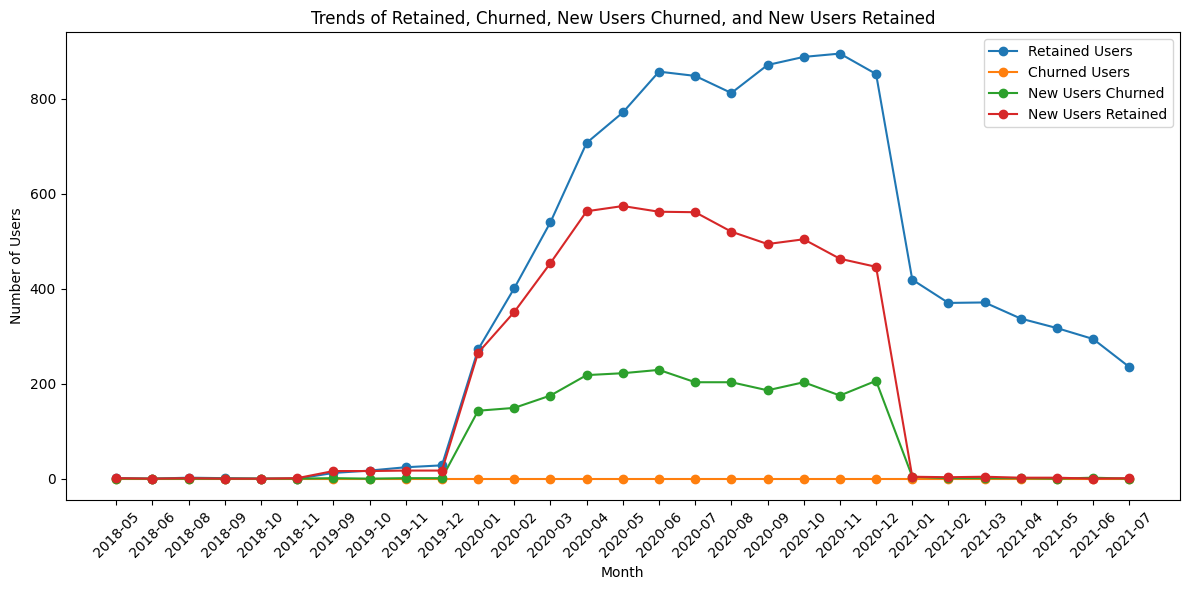

       Unnamed: 0                  ts                                 user_id  \
18310       18310 2018-06-05 01:44:55  19658830871438979514127794516905560769   

            os  browser    plan    page    month first_month last_month  \
18310  windows  Firefox  yearly  coupon  2018-06     2018-05    2020-03   

      prev_month next_month  
18310    2018-05    2018-07  
        Unnamed: 0                  ts  \
145297      145297 2018-05-25 01:32:57   
5641          5641 2018-05-25 01:33:00   
7936          7936 2018-05-25 01:33:48   
18310        18310 2018-06-05 01:44:55   
5642          5642 2018-08-29 07:44:18   
31968        31968 2018-08-29 08:12:03   
31969        31969 2018-10-09 23:32:31   
37381        37381 2020-03-23 00:30:51   
129678      129678 2020-03-23 00:30:53   
155427      155427 2020-03-23 00:30:55   
98612        98612 2020-03-23 00:33:05   
126594      126594 2020-03-23 00:33:13   

                                       user_id       os  browser    plan  \
145

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')
df.dropna(inplace=True)
# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the month from the timestamp
df['month'] = df['ts'].dt.to_period('M')

# Sort the dataframe by user_id and timestamp
df = df.sort_values(by=['user_id', 'ts'])

# Identify the first and last month each user appeared
df['first_month'] = df.groupby('user_id')['month'].transform('min')
df['last_month'] = df.groupby('user_id')['month'].transform('max')

# Display the first few rows of the DataFrame
print(df.head())
# Identify users with tasks in the previous month
df['prev_month'] = df['month'] - 1
users_with_prev_month_tasks = df[df.duplicated(['user_id', 'prev_month'], keep=False)]

# Identify users with tasks in the next month
df['next_month'] = df['month'] + 1
users_with_next_month_tasks = df[df.duplicated(['user_id', 'next_month'], keep=False)]

# Identify users with tasks in the current month
users_with_current_month_tasks = df[df.duplicated(['user_id', 'month'], keep=False)]

# Retained users: users with tasks in the previous or current month and also in the following months
retained_users = pd.concat([users_with_prev_month_tasks, users_with_current_month_tasks])
retained_users = retained_users[retained_users['user_id'].isin(users_with_next_month_tasks['user_id'])]

# Display the retained users dataframe
print(retained_users.head())

# Churned users: users with tasks in the previous months but not in the current or any following months
churned_users = users_with_prev_month_tasks[~users_with_prev_month_tasks['user_id'].isin(users_with_current_month_tasks['user_id']) & ~users_with_prev_month_tasks['user_id'].isin(users_with_next_month_tasks['user_id'])]

# Display the churned users dataframe
print(churned_users.head())

# Identify new users for each month
new_users = df[df['month'] == df['first_month']]

# New users churned: new users who do not have tasks in any following months
new_users_churned = new_users[~new_users['user_id'].isin(users_with_next_month_tasks['user_id'])]

# Display the new users churned dataframe
print(new_users_churned.head())

# New users retained: new users who have tasks in the current and following months
new_users_retained = new_users[new_users['user_id'].isin(users_with_next_month_tasks['user_id'])]

# Display the new users retained dataframe
print(new_users_retained.head())

# Calculate total users per month
total_users_per_month = df.groupby('month')['user_id'].nunique().reset_index(name='total_users')

# Calculate retained users per month
retained_users_per_month = retained_users.groupby('month')['user_id'].nunique().reset_index(name='retained_users')

# Calculate churned users per month
churned_users_per_month = churned_users.groupby('month')['user_id'].nunique().reset_index(name='churned_users')

# Calculate new users churned per month
new_users_churned_per_month = new_users_churned.groupby('month')['user_id'].nunique().reset_index(name='new_users_churned')

# Calculate new users retained per month
new_users_retained_per_month = new_users_retained.groupby('month')['user_id'].nunique().reset_index(name='new_users_retained')

# Merge dataframes to get total users, retained users, churned users, new users churned, and new users retained per month
user_metrics = total_users_per_month.merge(retained_users_per_month, on='month', how='left').merge(churned_users_per_month, on='month', how='left').merge(new_users_churned_per_month, on='month', how='left').merge(new_users_retained_per_month, on='month', how='left').fillna(0)

# Display the user metrics data
print(user_metrics)

# Plot the trends
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(user_metrics['month'].astype(str), user_metrics['retained_users'], marker='o', label='Retained Users')
ax.plot(user_metrics['month'].astype(str), user_metrics['churned_users'], marker='o', label='Churned Users')
ax.plot(user_metrics['month'].astype(str), user_metrics['new_users_churned'], marker='o', label='New Users Churned')
ax.plot(user_metrics['month'].astype(str), user_metrics['new_users_retained'], marker='o', label='New Users Retained')

ax.set_xlabel('Month')
ax.set_ylabel('Number of Users')
ax.set_title('Trends of Retained, Churned, New Users Churned, and New Users Retained')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

june_2018_data = df[df['month'] == '2018-06']
print(june_2018_data)
user_id_june_2018 = june_2018_data['user_id'].unique()
tasks_user_june_2018 = df[df['user_id'].isin(user_id_june_2018)]
print(tasks_user_june_2018)

        Unnamed: 0                  ts  \
61458        61458 2020-10-16 09:28:43   
23262        23262 2020-10-16 09:30:56   
139163      139163 2020-10-16 09:30:56   
31739        31739 2020-10-16 09:32:12   
30085        30085 2020-10-16 09:33:08   

                                        user_id       os  browser     plan  \
61458   100057565415361423597239221229734238436  windows  Firefox  monthly   
23262   100057565415361423597239221229734238436  windows  Firefox  monthly   
139163  100057565415361423597239221229734238436  windows  Firefox  monthly   
31739   100057565415361423597239221229734238436  windows  Firefox  monthly   
30085   100057565415361423597239221229734238436  windows  Firefox  monthly   

         page    month first_month last_month  
61458   merge  2020-10     2020-10    2020-10  
23262   merge  2020-10     2020-10    2020-10  
139163  merge  2020-10     2020-10    2020-10  
31739    edit  2020-10     2020-10    2020-10  
30085   merge  2020-10     2020-10    

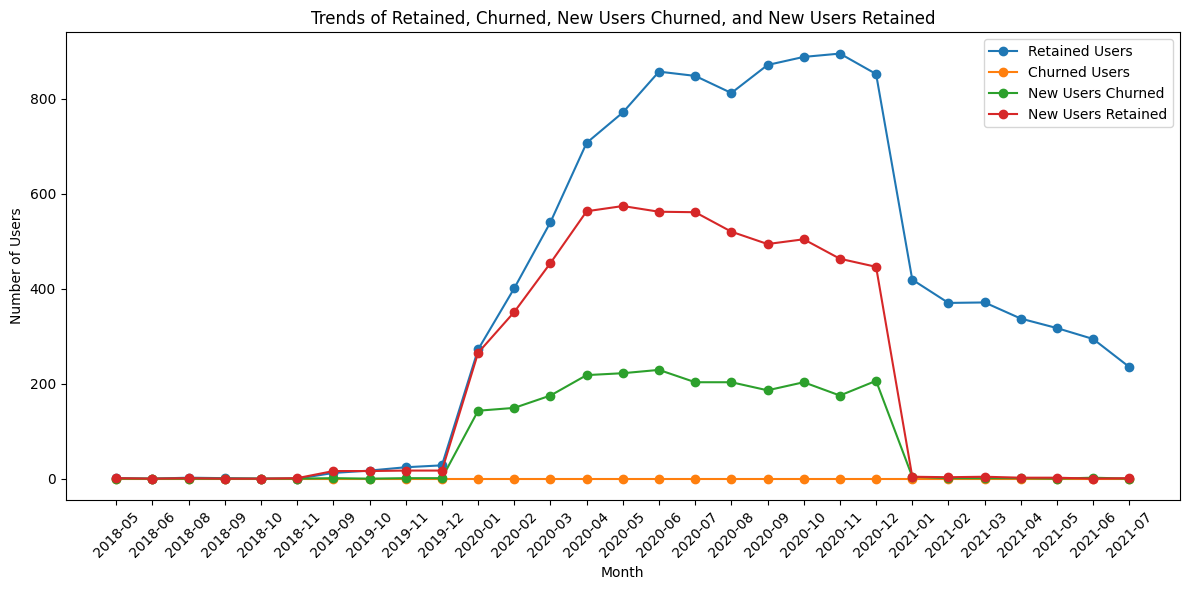

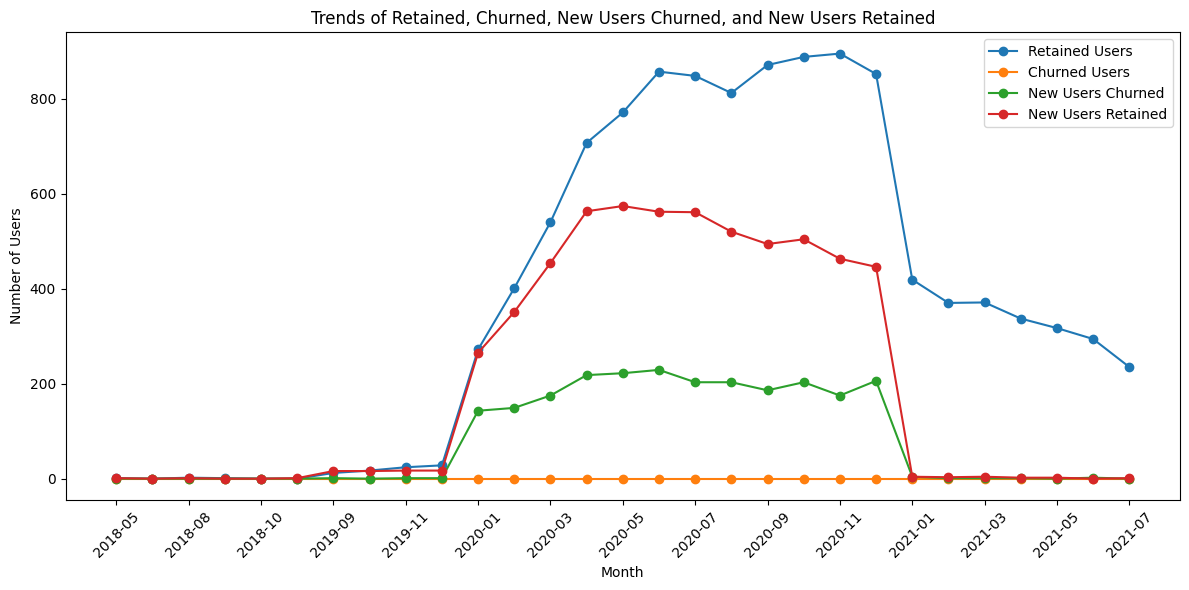

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')
df.dropna(inplace=True)
# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the month from the timestamp
df['month'] = df['ts'].dt.to_period('M')

# Sort the dataframe by user_id and timestamp
df = df.sort_values(by=['user_id', 'ts'])

# Identify the first and last month each user appeared
df['first_month'] = df.groupby('user_id')['month'].transform('min')
df['last_month'] = df.groupby('user_id')['month'].transform('max')

# Display the first few rows of the DataFrame
print(df.head())
# Identify users with tasks in the previous month
df['prev_month'] = df['month'] - 1
users_with_prev_month_tasks = df[df.duplicated(['user_id', 'prev_month'], keep=False)]

# Identify users with tasks in the next month
df['next_month'] = df['month'] + 1
users_with_next_month_tasks = df[df.duplicated(['user_id', 'next_month'], keep=False)]

# Identify users with tasks in the current month
users_with_current_month_tasks = df[df.duplicated(['user_id', 'month'], keep=False)]

# Retained users: users with tasks in the previous or current month and also in the following months
retained_users = users_with_current_month_tasks[users_with_current_month_tasks['user_id'].isin(users_with_next_month_tasks['user_id']) | users_with_current_month_tasks['user_id'].isin(users_with_prev_month_tasks['user_id'])]

# Display the retained users dataframe
print(retained_users.head())

churned_users = users_with_prev_month_tasks[
    ~users_with_prev_month_tasks['user_id'].isin(users_with_current_month_tasks['user_id']) & 
    ~users_with_prev_month_tasks['user_id'].isin(users_with_next_month_tasks['user_id'])
]

# Display the churned users dataframe
print(churned_users.head())

# Identify new users for each month
new_users = df[df['month'] == df['first_month']]

# New users churned: new users who do not have tasks in any following months
new_users_churned = new_users[~new_users['user_id'].isin(users_with_next_month_tasks['user_id'])]

# Display the new users churned dataframe
#print(new_users_churned.head())

# New users retained: new users who have tasks in the current and following months
new_users_retained = new_users[new_users['user_id'].isin(users_with_next_month_tasks['user_id'])]

# Display the new users retained dataframe
#print(new_users_retained.head())

# Calculate total users per month
total_users_per_month = df.groupby('month')['user_id'].nunique().reset_index(name='total_users')

# Calculate retained users per month
retained_users_per_month = retained_users.groupby('month')['user_id'].nunique().reset_index(name='retained_users')

# Calculate churned users per month
churned_users_per_month = churned_users.groupby('month')['user_id'].nunique().reset_index(name='churned_users')

# Calculate new users churned per month
new_users_churned_per_month = new_users_churned.groupby('month')['user_id'].nunique().reset_index(name='new_users_churned')

# Calculate new users retained per month
new_users_retained_per_month = new_users_retained.groupby('month')['user_id'].nunique().reset_index(name='new_users_retained')

# Merge dataframes to get total users, retained users, churned users, new users churned, and new users retained per month
user_metrics = total_users_per_month.merge(retained_users_per_month, on='month', how='left').merge(churned_users_per_month, on='month', how='left').merge(new_users_churned_per_month, on='month', how='left').merge(new_users_retained_per_month, on='month', how='left').fillna(0)

# Display the user metrics data
#print(user_metrics)
# Plot the trends
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(user_metrics['month'].astype(str), user_metrics['retained_users'], marker='o', label='Retained Users')
ax.plot(user_metrics['month'].astype(str), user_metrics['churned_users'], marker='o', label='Churned Users')
ax.plot(user_metrics['month'].astype(str), user_metrics['new_users_churned'], marker='o', label='New Users Churned')
ax.plot(user_metrics['month'].astype(str), user_metrics['new_users_retained'], marker='o', label='New Users Retained')

ax.set_xlabel('Month')
ax.set_ylabel('Number of Users')
ax.set_title('Trends of Retained, Churned, New Users Churned, and New Users Retained')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Plot the trends
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(user_metrics['month'].astype(str), user_metrics['retained_users'], marker='o', label='Retained Users')
ax.plot(user_metrics['month'].astype(str), user_metrics['churned_users'], marker='o', label='Churned Users')
ax.plot(user_metrics['month'].astype(str), user_metrics['new_users_churned'], marker='o', label='New Users Churned')
ax.plot(user_metrics['month'].astype(str), user_metrics['new_users_retained'], marker='o', label='New Users Retained')

ax.set_xlabel('Month')
ax.set_ylabel('Number of Users')
ax.set_title('Trends of Retained, Churned, New Users Churned, and New Users Retained')
ax.legend()

# Fix overlapping month labels
plt.xticks(ticks=range(0, len(user_metrics['month']), max(1, len(user_metrics['month']) // 12)), labels=user_metrics['month'].astype(str).tolist()[::max(1, len(user_metrics['month']) // 12)], rotation=45)
plt.tight_layout()
plt.show()

      month  total_users  retained_users  churned_users  retention_rate  \
0   2018-05            1             1.0              1      100.000000   
1   2018-06            1             0.0              1        0.000000   
2   2018-08            2             2.0              2      100.000000   
3   2018-09            1             1.0              1      100.000000   
4   2018-10            1             0.0              1        0.000000   
5   2018-11            1             0.0              1        0.000000   
6   2019-09           17            12.0             16       70.588235   
7   2019-10           23            17.0             23       73.913043   
8   2019-11           30            24.0             29       80.000000   
9   2019-12           38            28.0             37       73.684211   
10  2020-01          437           272.0            293       62.242563   
11  2020-02          591           401.0            437       67.851100   
12  2020-03          765 

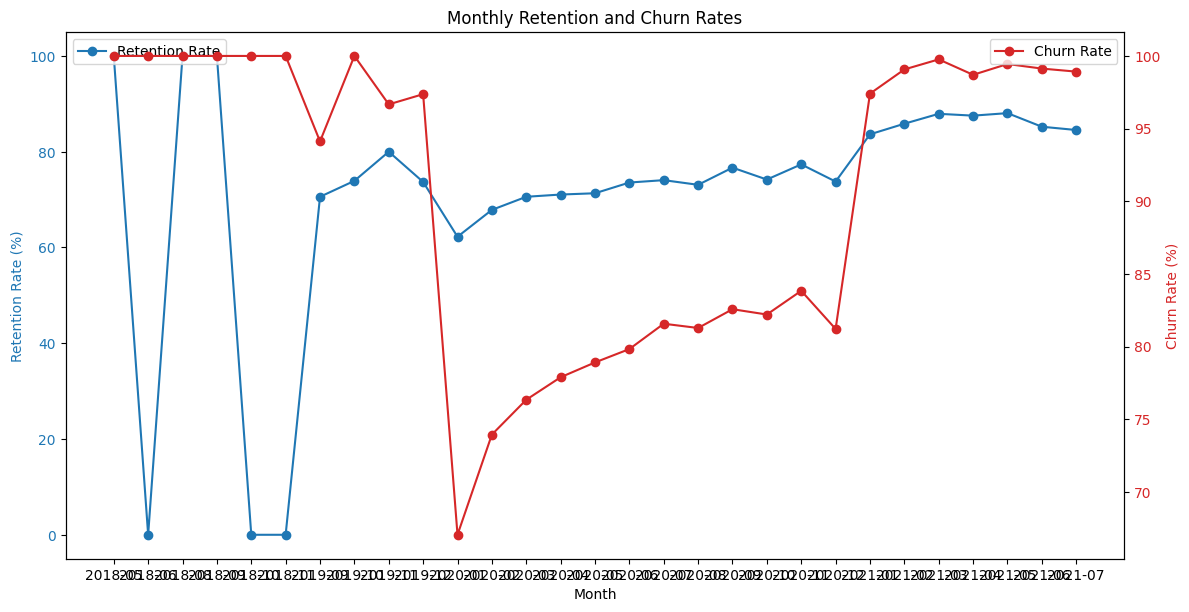

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')
df.dropna(inplace=True)
# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the month from the timestamp
df['month'] = df['ts'].dt.to_period('M')

# Sort the dataframe by user_id and timestamp
df = df.sort_values(by=['user_id', 'ts'])

# Identify the first and last month each user appeared
df['first_month'] = df.groupby('user_id')['month'].transform('min')
df['last_month'] = df.groupby('user_id')['month'].transform('max')

# Identify users with tasks in the previous month
df['prev_month'] = df['month'] - 1
users_with_prev_month_tasks = df[df.duplicated(['user_id', 'prev_month'], keep=False)]

# Identify users with tasks in the next month
df['next_month'] = df['month'] + 1
users_with_next_month_tasks = df[df.duplicated(['user_id', 'next_month'], keep=False)]

# Retained users: users with tasks in both current and next months
retained_users = users_with_prev_month_tasks[users_with_prev_month_tasks['user_id'].isin(users_with_next_month_tasks['user_id'])]

# Churned users: users with tasks in the previous month but not in the current or any upcoming month
churned_users = df[(df['month'] < df['next_month']) & (~df['user_id'].isin(df[df['month'] >= df['next_month']]['user_id'])) & (df['user_id'].isin(users_with_prev_month_tasks['user_id']))]

# Calculate total users per month
total_users_per_month = df.groupby('month')['user_id'].nunique().reset_index(name='total_users')

# Calculate retained users per month
retained_users_per_month = retained_users.groupby('month')['user_id'].nunique().reset_index(name='retained_users')

# Calculate churned users per month
churned_users_per_month = churned_users.groupby('month')['user_id'].nunique().reset_index(name='churned_users')

# Merge dataframes to get total users, retained users, and churned users per month
user_metrics = total_users_per_month.merge(retained_users_per_month, on='month', how='left').merge(churned_users_per_month, on='month', how='left').fillna(0)

# Calculate retention and churn rates
user_metrics['retention_rate'] = (user_metrics['retained_users'] / user_metrics['total_users']) * 100
user_metrics['churn_rate'] = (user_metrics['churned_users'] / user_metrics['total_users']) * 100

# Display the user metrics data
print(user_metrics)

# Plot the retention and churn rates
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Retention Rate (%)', color=color)
ax1.plot(user_metrics['month'].astype(str), user_metrics['retention_rate'], marker='o', color=color, label='Retention Rate')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Churn Rate (%)', color=color)
ax2.plot(user_metrics['month'].astype(str), user_metrics['churn_rate'], marker='o', color=color, label='Churn Rate')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()
plt.title('Monthly Retention and Churn Rates')
plt.xticks(rotation=45)
plt.show()


        Unnamed: 0                  ts  \
61458        61458 2020-10-16 09:28:43   
23262        23262 2020-10-16 09:30:56   
139163      139163 2020-10-16 09:30:56   
31739        31739 2020-10-16 09:32:12   
30085        30085 2020-10-16 09:33:08   

                                        user_id       os  browser     plan  \
61458   100057565415361423597239221229734238436  windows  Firefox  monthly   
23262   100057565415361423597239221229734238436  windows  Firefox  monthly   
139163  100057565415361423597239221229734238436  windows  Firefox  monthly   
31739   100057565415361423597239221229734238436  windows  Firefox  monthly   
30085   100057565415361423597239221229734238436  windows  Firefox  monthly   

         page    month first_month last_month  
61458   merge  2020-10     2020-10    2020-10  
23262   merge  2020-10     2020-10    2020-10  
139163  merge  2020-10     2020-10    2020-10  
31739    edit  2020-10     2020-10    2020-10  
30085   merge  2020-10     2020-10    

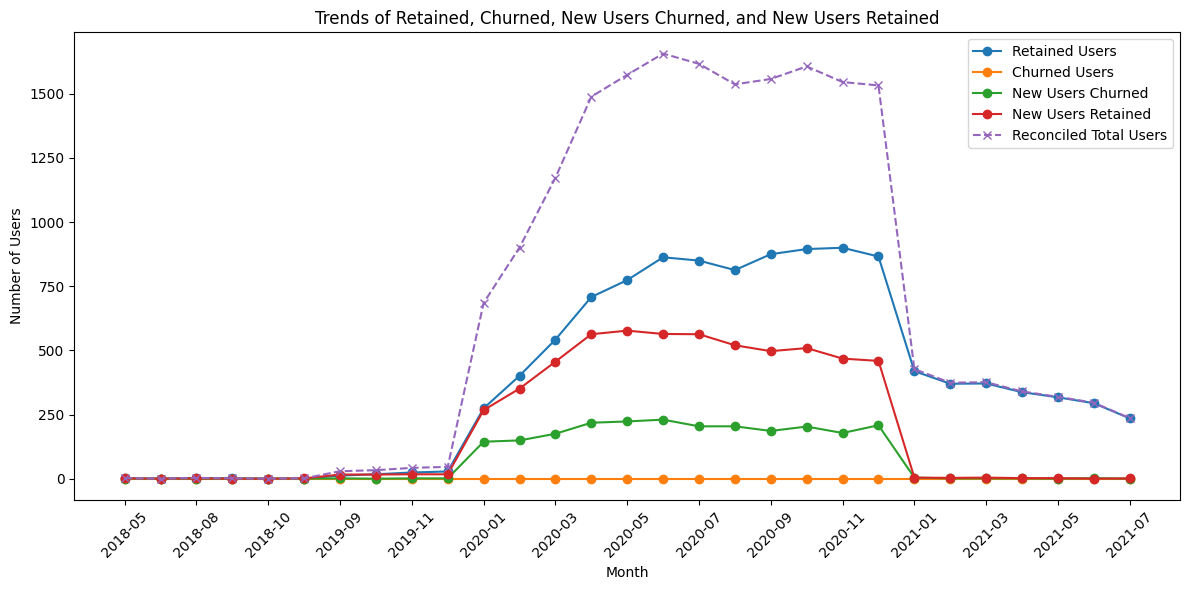

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the month from the timestamp
df['month'] = df['ts'].dt.to_period('M')

# Sort the dataframe by user_id and timestamp
df = df.sort_values(by=['user_id', 'ts'])

# Identify the first and last month each user appeared
df['first_month'] = df.groupby('user_id')['month'].transform('min')
df['last_month'] = df.groupby('user_id')['month'].transform('max')

# Display the first few rows of the DataFrame
print(df.head())
# Identify users with tasks in the previous month
df['prev_month'] = df['month'] - 1
users_with_prev_month_tasks = df[df.duplicated(['user_id', 'prev_month'], keep=False)]

# Identify users with tasks in the next month
df['next_month'] = df['month'] + 1
users_with_next_month_tasks = df[df.duplicated(['user_id', 'next_month'], keep=False)]

# Identify users with tasks in the current month
users_with_current_month_tasks = df[df.duplicated(['user_id', 'month'], keep=False)]

# Retained users: users with tasks in the previous or current month and also in the following months
retained_users = users_with_current_month_tasks[
    users_with_current_month_tasks['user_id'].isin(users_with_prev_month_tasks['user_id']) | 
    users_with_current_month_tasks['user_id'].isin(users_with_next_month_tasks['user_id'])
]

# Display the retained users dataframe
print(retained_users.head())
# Churned users: users with tasks in the previous months but not in the current or any following months
churned_users = users_with_prev_month_tasks[
    ~users_with_prev_month_tasks['user_id'].isin(users_with_current_month_tasks['user_id']) & 
    ~users_with_prev_month_tasks['user_id'].isin(users_with_next_month_tasks['user_id'])
]

# Display the churned users dataframe
print(churned_users.head())
# Identify new users for each month
new_users = df[df['month'] == df['first_month']]

# New users churned: new users who do not have tasks in any following months
new_users_churned = new_users[~new_users['user_id'].isin(users_with_next_month_tasks['user_id'])]

# Display the new users churned dataframe
print(new_users_churned.head())
# New users retained: new users who have tasks in the current and following months
new_users_retained = new_users[new_users['user_id'].isin(users_with_next_month_tasks['user_id'])]

# Display the new users retained dataframe
print(new_users_retained.head())
# Calculate total users per month
total_users_per_month = df.groupby('month')['user_id'].nunique().reset_index(name='total_users')

# Calculate retained users per month (only those who have tasks in the current month)
retained_users_per_month = retained_users.groupby('month')['user_id'].nunique().reset_index(name='retained_users')

# Calculate churned users per month
churned_users_per_month = churned_users.groupby('month')['user_id'].nunique().reset_index(name='churned_users')

# Calculate new users churned per month
new_users_churned_per_month = new_users_churned.groupby('month')['user_id'].nunique().reset_index(name='new_users_churned')

# Calculate new users retained per month
new_users_retained_per_month = new_users_retained.groupby('month')['user_id'].nunique().reset_index(name='new_users_retained')

# Merge dataframes to get total users, retained users, churned users, new users churned, and new users retained per month
user_metrics = total_users_per_month.merge(retained_users_per_month, on='month', how='left').merge(churned_users_per_month, on='month', how='left').merge(new_users_churned_per_month, on='month', how='left').merge(new_users_retained_per_month, on='month', how='left').fillna(0)

# Ensure total users reconcile
user_metrics['reconciled_total_users'] = user_metrics['retained_users'] + user_metrics['new_users_churned'] + user_metrics['new_users_retained']

# Display the user metrics data
print(user_metrics)
# Plot the trends
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(user_metrics['month'].astype(str), user_metrics['retained_users'], marker='o', label='Retained Users')
ax.plot(user_metrics['month'].astype(str), user_metrics['churned_users'], marker='o', label='Churned Users')
ax.plot(user_metrics['month'].astype(str), user_metrics['new_users_churned'], marker='o', label='New Users Churned')
ax.plot(user_metrics['month'].astype(str), user_metrics['new_users_retained'], marker='o', label='New Users Retained')
ax.plot(user_metrics['month'].astype(str), user_metrics['reconciled_total_users'], marker='x', linestyle='--', label='Reconciled Total Users')

ax.set_xlabel('Month')
ax.set_ylabel('Number of Users')
ax.set_title('Trends of Retained, Churned, New Users Churned, and New Users Retained')
ax.legend()

# Fix overlapping month labels
plt.xticks(ticks=range(0, len(user_metrics['month']), max(1, len(user_metrics['month']) // 12)), labels=user_metrics['month'].astype(str).tolist()[::max(1, len(user_metrics['month']) // 12)], rotation=45)
plt.tight_layout()
plt.show()


      month  average_active_days
0   2018-05             1.000000
1   2018-06             1.000000
2   2018-08             1.500000
3   2018-09             4.000000
4   2018-10             1.000000
5   2018-11             1.000000
6   2019-09             1.882353
7   2019-10             3.043478
8   2019-11             2.966667
9   2019-12             2.473684
10  2020-01             1.604119
11  2020-02             1.615905
12  2020-03             1.955556
13  2020-04             2.188945
14  2020-05             2.300648
15  2020-06             2.310730
16  2020-07             2.422707
17  2020-08             2.296130
18  2020-09             2.465669
19  2020-10             2.380117
20  2020-11             2.424373
21  2020-12             2.293506
22  2021-01             3.610778
23  2021-02             3.911833
24  2021-03             4.270142
25  2021-04             4.306494
26  2021-05             4.313889
27  2021-06             4.321739
28  2021-07             3.633094


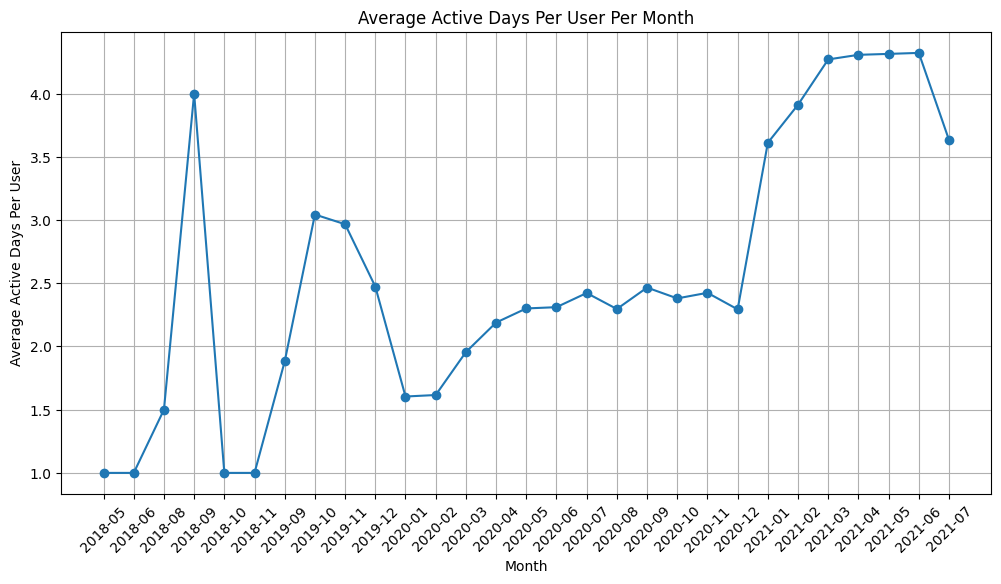

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')
df.dropna(inplace=True)
# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the month from the timestamp
df['month'] = df['ts'].dt.to_period('M')

# Extract the day from the timestamp
df['day'] = df['ts'].dt.day

# Count the number of active days for each user in each month
active_days_per_user = df.groupby(['user_id', 'month'])['day'].nunique().reset_index()
active_days_per_user.columns = ['user_id', 'month', 'active_days']

# Calculate the average number of active days per user for each month
average_active_days_per_month = active_days_per_user.groupby('month')['active_days'].mean().reset_index()
average_active_days_per_month.columns = ['month', 'average_active_days']

# Display the average active days per user for each month
print(average_active_days_per_month)

# Plot the average active days per user for each month
plt.figure(figsize=(12, 6))
plt.plot(average_active_days_per_month['month'].astype(str), average_active_days_per_month['average_active_days'], marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Average Active Days Per User')
plt.title('Average Active Days Per User Per Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Retention DataFrame head:
                                   user_id    month  active_days  \
0  100057565415361423597239221229734238436  2020-10            1   
1   10008297250197642640412434822899674026  2020-05            1   
2  100103232984930506871964919813308121190  2020-06            1   
3  100103232984930506871964919813308121190  2020-07           11   
4   10018205113995011172245539900161896237  2020-01            1   

  last_active_month next_month  retained  
0           2020-10    2020-11         0  
1           2020-05    2020-06         0  
2           2020-07    2020-07         1  
3           2020-07    2020-08         0  
4           2020-01    2020-02         0  
Unique values in 'retained' column:
[0 1]
Distribution of retained users:
retained
0    8166
1    6606
Name: count, dtype: int64
Correlation between active days and retention:
             active_days  retained
active_days     1.000000  0.378482
retained        0.378482  1.000000


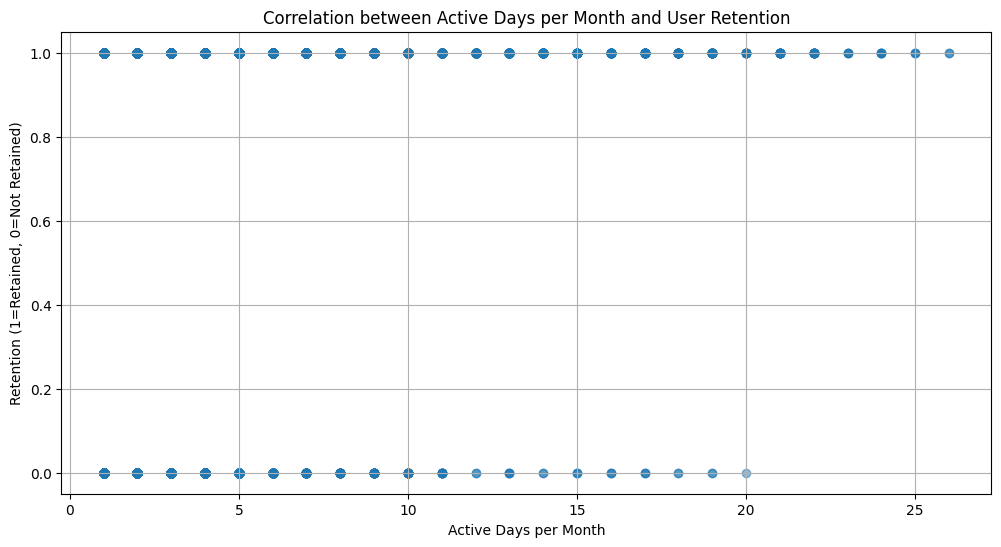

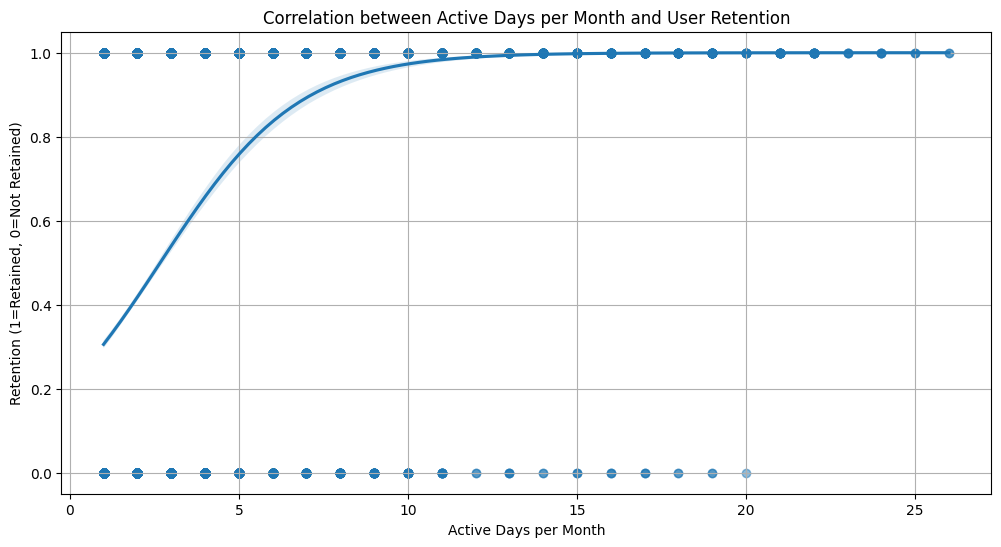

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')
df.dropna(inplace=True)

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the month and day from the timestamp
df['month'] = df['ts'].dt.to_period('M')
df['day'] = df['ts'].dt.day

# Count the number of active days for each user in each month
active_days_per_user = df.groupby(['user_id', 'month'])['day'].nunique().reset_index()
active_days_per_user.columns = ['user_id', 'month', 'active_days']

# Identify the last month each user was active
last_active_month = active_days_per_user.groupby('user_id')['month'].max().reset_index()
last_active_month.columns = ['user_id', 'last_active_month']

# Merge to find if the user is active in the next month
active_days_per_user = active_days_per_user.merge(last_active_month, on='user_id', how='left')
active_days_per_user['next_month'] = active_days_per_user['month'] + 1

# Define retention
active_days_per_user['retained'] = (active_days_per_user['next_month'] <= active_days_per_user['last_active_month']).astype(int)

# Inspect the retention DataFrame
print("Retention DataFrame head:")
print(active_days_per_user.head())

print("Unique values in 'retained' column:")
print(active_days_per_user['retained'].unique())

print("Distribution of retained users:")
print(active_days_per_user['retained'].value_counts())

# Analyze correlation
correlation = active_days_per_user[['active_days', 'retained']].corr()

# Display the correlation matrix
print("Correlation between active days and retention:")
print(correlation)

# Plot the relationship
plt.figure(figsize=(12, 6))
plt.scatter(active_days_per_user['active_days'], active_days_per_user['retained'], alpha=0.5)
plt.xlabel('Active Days per Month')
plt.ylabel('Retention (1=Retained, 0=Not Retained)')
plt.title('Correlation between Active Days per Month and User Retention')
plt.grid(True)
plt.show()
import seaborn as sns

# Plot the relationship with a trend line
plt.figure(figsize=(12, 6))
sns.regplot(x='active_days', y='retained', data=active_days_per_user, logistic=True, scatter_kws={'alpha':0.5})
plt.xlabel('Active Days per Month')
plt.ylabel('Retention (1=Retained, 0=Not Retained)')
plt.title('Correlation between Active Days per Month and User Retention')
plt.grid(True)
plt.show()

In [14]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')
df.dropna(inplace=True)

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the month and day from the timestamp
df['month'] = df['ts'].dt.to_period('M')
df['day'] = df['ts'].dt.day

# Identify the month each user first used the product
df['first_month'] = df.groupby('user_id')['month'].transform('min')

# Count the number of active days for each user in each month
active_days_per_user = df.groupby(['user_id', 'month'])['day'].nunique().reset_index()
active_days_per_user.columns = ['user_id', 'month', 'active_days']

# Merge with the first month information
active_days_per_user = active_days_per_user.merge(df[['user_id', 'first_month']].drop_duplicates(), on='user_id')

# Identify users who churned within the first month
active_days_per_user['next_month'] = active_days_per_user['month'] + 1
last_active_month = active_days_per_user.groupby('user_id')['month'].max().reset_index()
last_active_month.columns = ['user_id', 'last_active_month']
active_days_per_user = active_days_per_user.merge(last_active_month, on='user_id', how='left')
active_days_per_user['retained'] = (active_days_per_user['next_month'] <= active_days_per_user['last_active_month']).astype(int)

# Filter for the first month data
first_month_data = active_days_per_user[active_days_per_user['month'] == active_days_per_user['first_month']]

# Calculate the average active days for churned and retained users
churned_users_first_month = first_month_data[first_month_data['retained'] == 0]['active_days'].mean()
retained_users_first_month = first_month_data[first_month_data['retained'] == 1]['active_days'].mean()

# Print the results
print(f"Average active days in first month for churned users: {churned_users_first_month:.2f}")
print(f"Average active days in first month for retained users: {retained_users_first_month:.2f}")


Average active days in first month for churned users: 1.37
Average active days in first month for retained users: 2.40


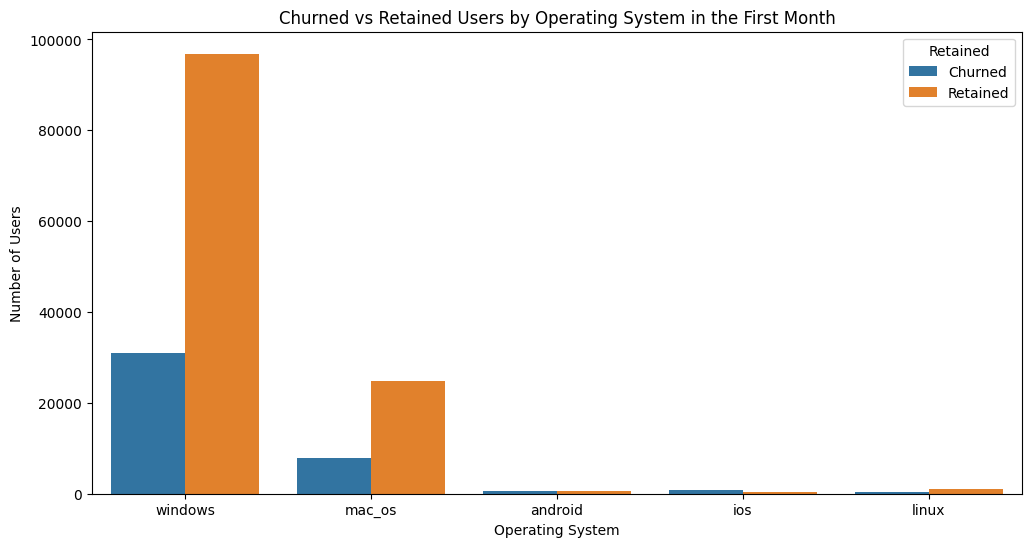

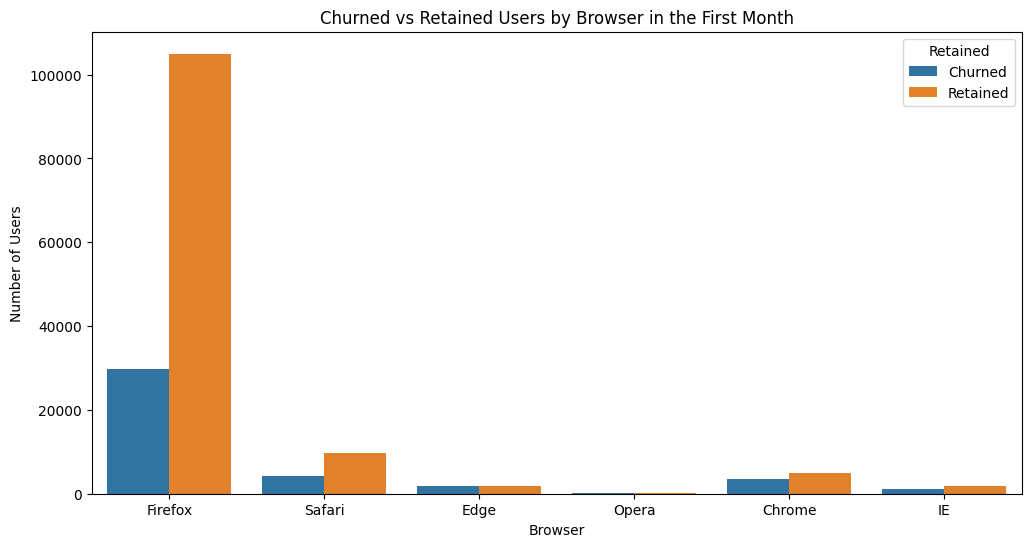

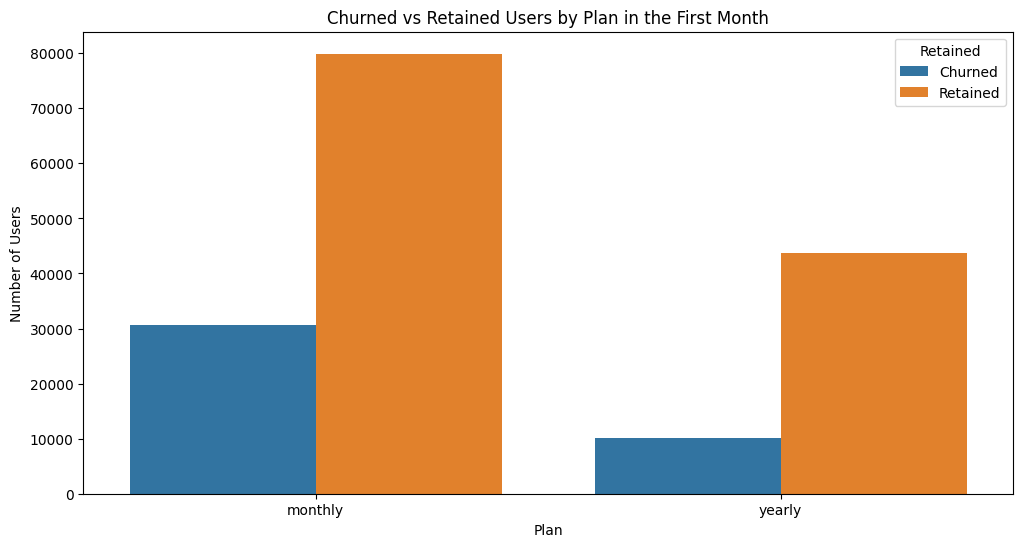

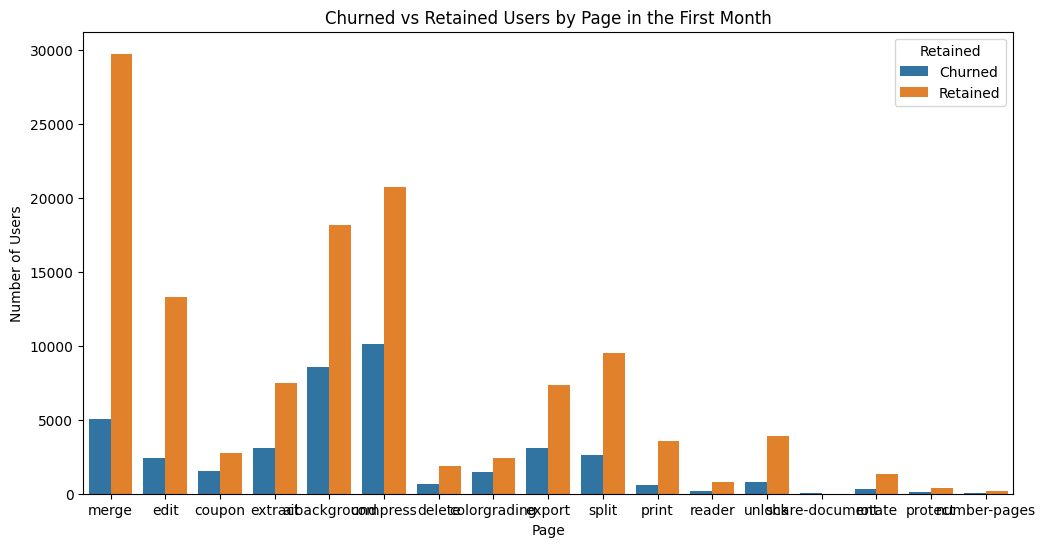

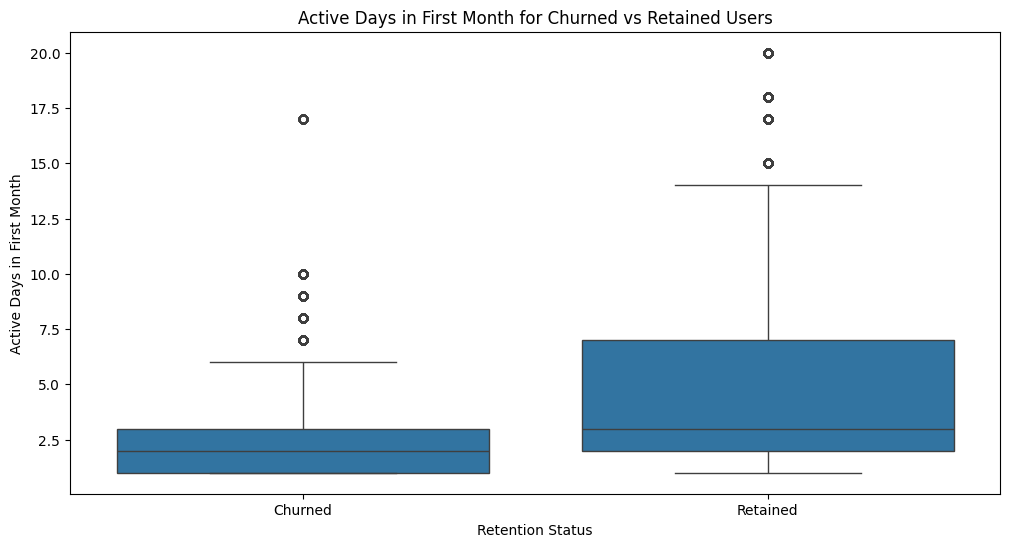

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a DataFrame
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')
df.dropna(inplace=True)

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the month and day from the timestamp
df['month'] = df['ts'].dt.to_period('M')
df['day'] = df['ts'].dt.day

# Identify the month each user first used the product
df['first_month'] = df.groupby('user_id')['month'].transform('min')

# Count the number of active days for each user in each month
active_days_per_user = df.groupby(['user_id', 'month'])['day'].nunique().reset_index()
active_days_per_user.columns = ['user_id', 'month', 'active_days']

# Merge with the first month information
active_days_per_user = active_days_per_user.merge(df[['user_id', 'first_month']].drop_duplicates(), on='user_id')

# Identify users who churned within the first month
active_days_per_user['next_month'] = active_days_per_user['month'] + 1
last_active_month = active_days_per_user.groupby('user_id')['month'].max().reset_index()
last_active_month.columns = ['user_id', 'last_active_month']
active_days_per_user = active_days_per_user.merge(last_active_month, on='user_id', how='left')
active_days_per_user['retained'] = (active_days_per_user['next_month'] <= active_days_per_user['last_active_month']).astype(int)

# Filter for the first month data
first_month_data = active_days_per_user[active_days_per_user['month'] == active_days_per_user['first_month']]

# Merge with the original dataframe to get the OS, browser, plan, and page data
first_month_data = first_month_data.merge(df[['user_id', 'os', 'browser', 'plan', 'page']], on='user_id')

# Plot the data

# OS
plt.figure(figsize=(12, 6))
sns.countplot(data=first_month_data, x='os', hue='retained')
plt.xlabel('Operating System')
plt.ylabel('Number of Users')
plt.title('Churned vs Retained Users by Operating System in the First Month')
plt.legend(title='Retained', labels=['Churned', 'Retained'])
plt.show()

# Browser
plt.figure(figsize=(12, 6))
sns.countplot(data=first_month_data, x='browser', hue='retained')
plt.xlabel('Browser')
plt.ylabel('Number of Users')
plt.title('Churned vs Retained Users by Browser in the First Month')
plt.legend(title='Retained', labels=['Churned', 'Retained'])
plt.show()

# Plan
plt.figure(figsize=(12, 6))
sns.countplot(data=first_month_data, x='plan', hue='retained')
plt.xlabel('Plan')
plt.ylabel('Number of Users')
plt.title('Churned vs Retained Users by Plan in the First Month')
plt.legend(title='Retained', labels=['Churned', 'Retained'])
plt.show()

# Page
plt.figure(figsize=(12, 6))
sns.countplot(data=first_month_data, x='page', hue='retained')
plt.xlabel('Page')
plt.ylabel('Number of Users')
plt.title('Churned vs Retained Users by Page in the First Month')
plt.legend(title='Retained', labels=['Churned', 'Retained'])
plt.show()

# Active Days
plt.figure(figsize=(12, 6))
sns.boxplot(data=first_month_data, x='retained', y='active_days')
plt.xlabel('Retention Status')
plt.ylabel('Active Days in First Month')
plt.title('Active Days in First Month for Churned vs Retained Users')
plt.xticks([0, 1], ['Churned', 'Retained'])
plt.show()


Chi-square test for OS: chi2 = 2089.8922959855154, p = 0.0
Chi-square test for Browser: chi2 = 3757.2661663913905, p = 0.0
Chi-square test for Plan: chi2 = 1574.998123485708, p = 0.0
Chi-square test for Page: chi2 = 5937.45449964136, p = 0.0
Point biserial correlation for Active Days: corr = 0.2552565177129519, p = 0.0


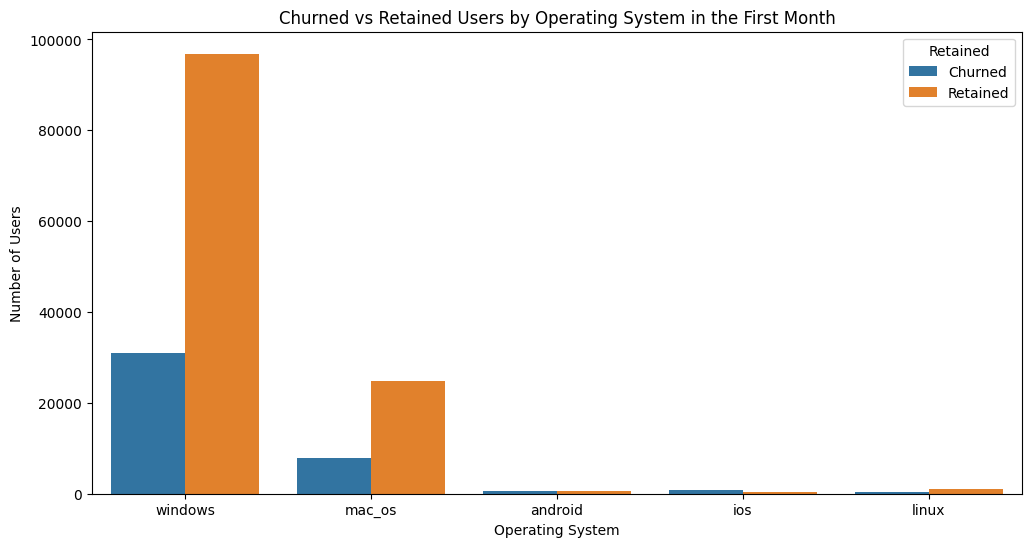

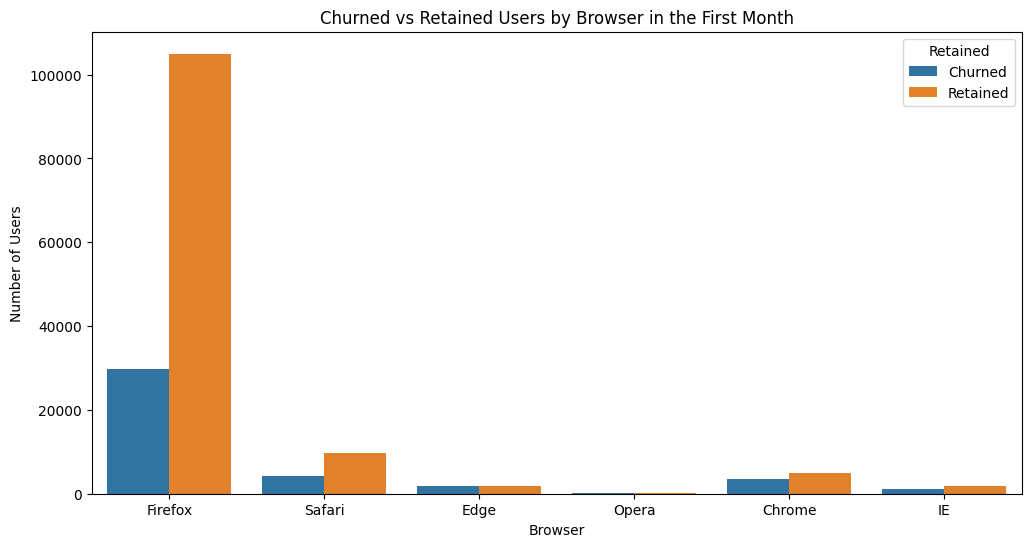

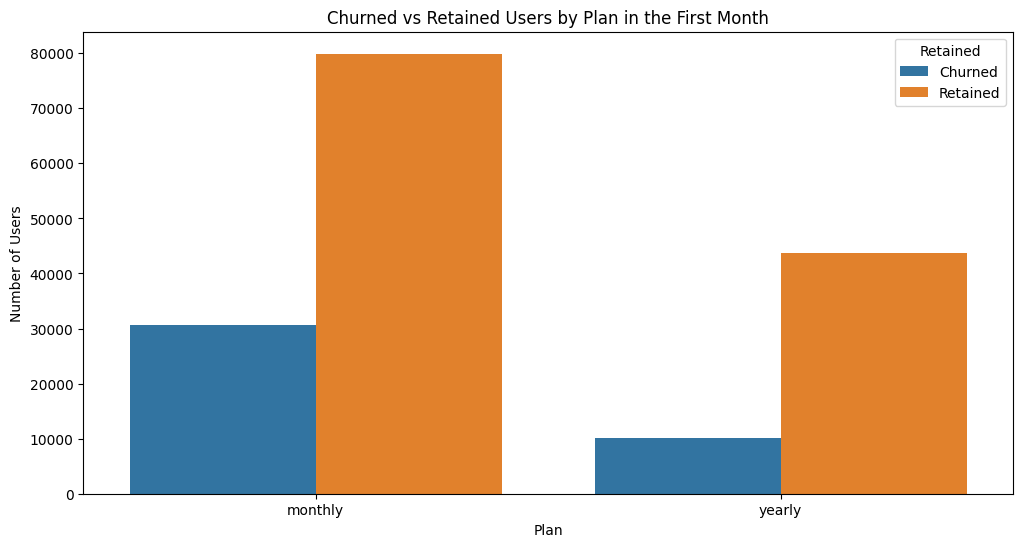

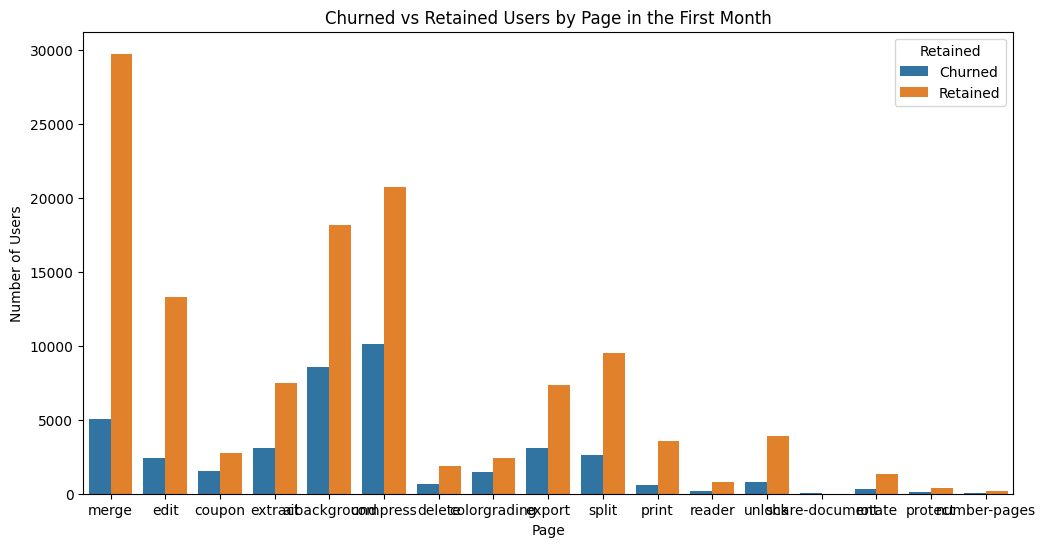

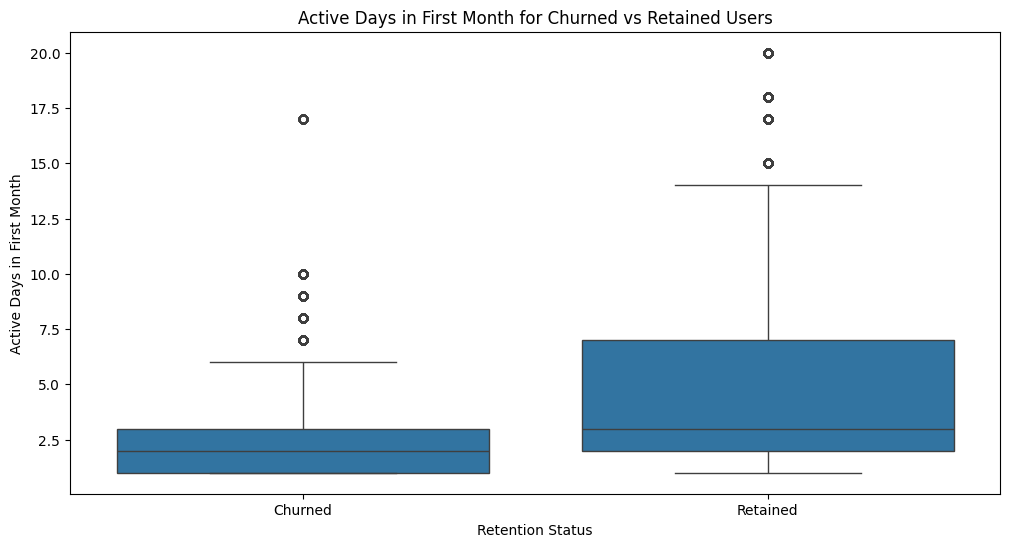

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pointbiserialr

# Load the CSV file into a DataFrame
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')
df.dropna(inplace=True)

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the month and day from the timestamp
df['month'] = df['ts'].dt.to_period('M')
df['day'] = df['ts'].dt.day

# Identify the month each user first used the product
df['first_month'] = df.groupby('user_id')['month'].transform('min')

# Count the number of active days for each user in each month
active_days_per_user = df.groupby(['user_id', 'month'])['day'].nunique().reset_index()
active_days_per_user.columns = ['user_id', 'month', 'active_days']

# Merge with the first month information
active_days_per_user = active_days_per_user.merge(df[['user_id', 'first_month']].drop_duplicates(), on='user_id')

# Identify users who churned within the first month
active_days_per_user['next_month'] = active_days_per_user['month'] + 1
last_active_month = active_days_per_user.groupby('user_id')['month'].max().reset_index()
last_active_month.columns = ['user_id', 'last_active_month']
active_days_per_user = active_days_per_user.merge(last_active_month, on='user_id', how='left')
active_days_per_user['retained'] = (active_days_per_user['next_month'] <= active_days_per_user['last_active_month']).astype(int)

# Filter for the first month data
first_month_data = active_days_per_user[active_days_per_user['month'] == active_days_per_user['first_month']]

# Merge with the original dataframe to get the OS, browser, plan, and page data
first_month_data = first_month_data.merge(df[['user_id', 'os', 'browser', 'plan', 'page']], on='user_id')

# Chi-square test for categorical variables
def chi_square_test(column):
    contingency_table = pd.crosstab(first_month_data[column], first_month_data['retained'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p

# Calculate chi-square for each categorical variable
chi2_os, p_os = chi_square_test('os')
chi2_browser, p_browser = chi_square_test('browser')
chi2_plan, p_plan = chi_square_test('plan')
chi2_page, p_page = chi_square_test('page')

# Point biserial correlation for active days
corr_active_days, p_active_days = pointbiserialr(first_month_data['retained'], first_month_data['active_days'])

# Print the results
print(f"Chi-square test for OS: chi2 = {chi2_os}, p = {p_os}")
print(f"Chi-square test for Browser: chi2 = {chi2_browser}, p = {p_browser}")
print(f"Chi-square test for Plan: chi2 = {chi2_plan}, p = {p_plan}")
print(f"Chi-square test for Page: chi2 = {chi2_page}, p = {p_page}")
print(f"Point biserial correlation for Active Days: corr = {corr_active_days}, p = {p_active_days}")

# Visualize the results

# OS
plt.figure(figsize=(12, 6))
sns.countplot(data=first_month_data, x='os', hue='retained')
plt.xlabel('Operating System')
plt.ylabel('Number of Users')
plt.title('Churned vs Retained Users by Operating System in the First Month')
plt.legend(title='Retained', labels=['Churned', 'Retained'])
plt.show()

# Browser
plt.figure(figsize=(12, 6))
sns.countplot(data=first_month_data, x='browser', hue='retained')
plt.xlabel('Browser')
plt.ylabel('Number of Users')
plt.title('Churned vs Retained Users by Browser in the First Month')
plt.legend(title='Retained', labels=['Churned', 'Retained'])
plt.show()

# Plan
plt.figure(figsize=(12, 6))
sns.countplot(data=first_month_data, x='plan', hue='retained')
plt.xlabel('Plan')
plt.ylabel('Number of Users')
plt.title('Churned vs Retained Users by Plan in the First Month')
plt.legend(title='Retained', labels=['Churned', 'Retained'])
plt.show()

# Page
plt.figure(figsize=(12, 6))
sns.countplot(data=first_month_data, x='page', hue='retained')
plt.xlabel('Page')
plt.ylabel('Number of Users')
plt.title('Churned vs Retained Users by Page in the First Month')
plt.legend(title='Retained', labels=['Churned', 'Retained'])
plt.show()

# Active Days
plt.figure(figsize=(12, 6))
sns.boxplot(data=first_month_data, x='retained', y='active_days')
plt.xlabel('Retention Status')
plt.ylabel('Active Days in First Month')
plt.title('Active Days in First Month for Churned vs Retained Users')
plt.xticks([0, 1], ['Churned', 'Retained'])
plt.show()


                     os_android    os_ios  os_linux  os_mac_os  os_windows  \
os_android             1.000000 -0.007437 -0.008002  -0.042873   -0.161608   
os_ios                -0.007437  1.000000 -0.008006  -0.042891   -0.161675   
os_linux              -0.008002 -0.008006  1.000000  -0.046155   -0.173978   
os_mac_os             -0.042873 -0.042891 -0.046155   1.000000   -0.932097   
os_windows            -0.161608 -0.161675 -0.173978  -0.932097    1.000000   
browser_Chrome        -0.019912 -0.017975 -0.006954  -0.050497    0.057827   
browser_Edge          -0.013263 -0.013268 -0.014278  -0.076494    0.082066   
browser_Firefox       -0.184121  0.034650  0.035194  -0.312699    0.323192   
browser_IE            -0.011889 -0.011894 -0.012799  -0.068570    0.073565   
browser_Opera         -0.003990  0.034506 -0.004295  -0.023012    0.016751   
browser_Safari         0.282357 -0.026337 -0.028342   0.547788   -0.572354   
plan_monthly          -0.016313 -0.003222  0.039609   0.039390  

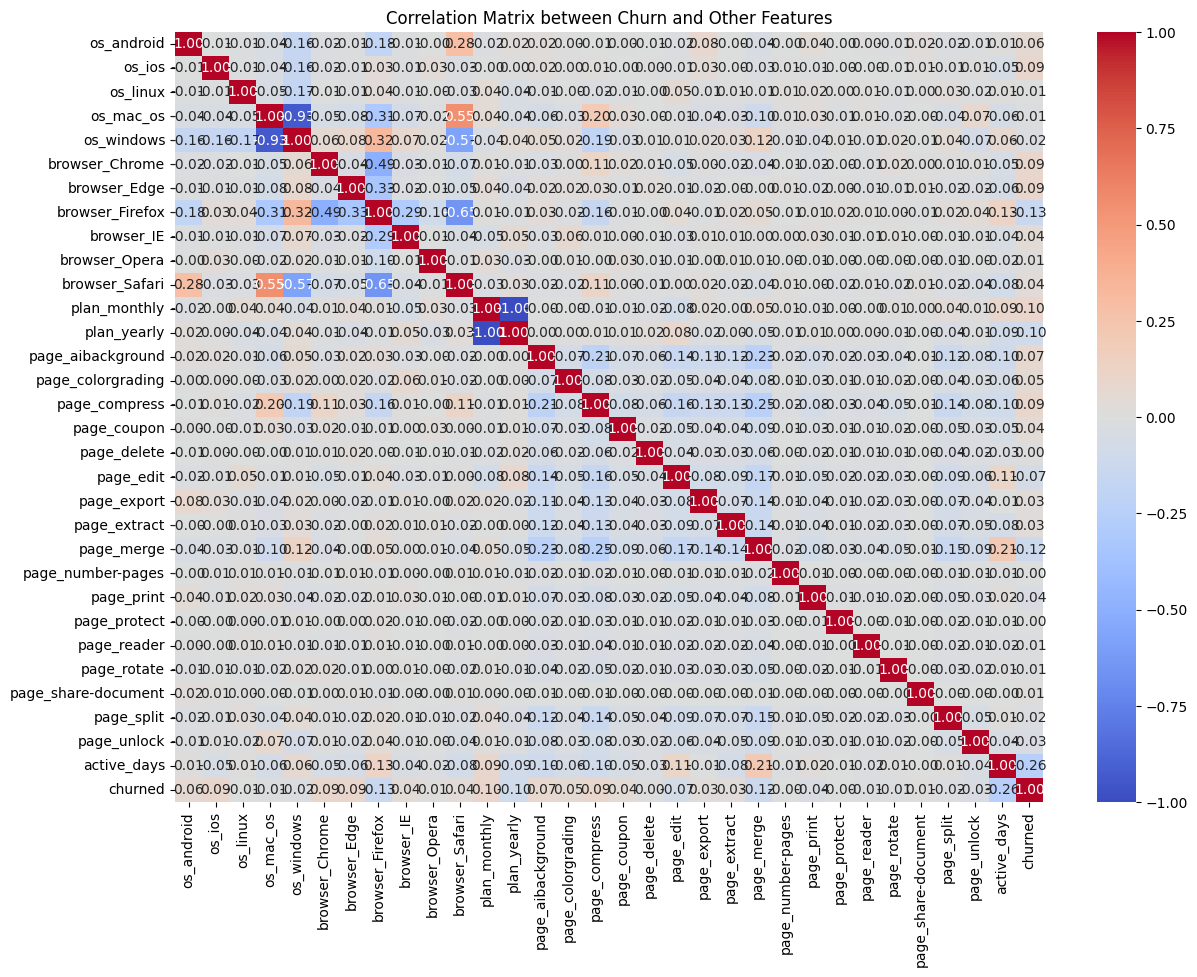

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Load the CSV file into a DataFrame
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')
df.dropna(inplace=True)

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the month and day from the timestamp
df['month'] = df['ts'].dt.to_period('M')
df['day'] = df['ts'].dt.day

# Identify the month each user first used the product
df['first_month'] = df.groupby('user_id')['month'].transform('min')

# Count the number of active days for each user in each month
active_days_per_user = df.groupby(['user_id', 'month'])['day'].nunique().reset_index()
active_days_per_user.columns = ['user_id', 'month', 'active_days']

# Merge with the first month information
active_days_per_user = active_days_per_user.merge(df[['user_id', 'first_month']].drop_duplicates(), on='user_id')

# Identify users who churned within the first month
active_days_per_user['next_month'] = active_days_per_user['month'] + 1
last_active_month = active_days_per_user.groupby('user_id')['month'].max().reset_index()
last_active_month.columns = ['user_id', 'last_active_month']
active_days_per_user = active_days_per_user.merge(last_active_month, on='user_id', how='left')
active_days_per_user['churned'] = (active_days_per_user['next_month'] > active_days_per_user['last_active_month']).astype(int)

# Filter for the first month data
first_month_data = active_days_per_user[active_days_per_user['month'] == active_days_per_user['first_month']]

# Merge with the original dataframe to get the OS, browser, plan, and page data
first_month_data = first_month_data.merge(df[['user_id', 'os', 'browser', 'plan', 'page']], on='user_id')

# One-hot encode the categorical variables
one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded_features = one_hot_encoder.fit_transform(first_month_data[['os', 'browser', 'plan', 'page']])
encoded_feature_names = one_hot_encoder.get_feature_names_out(['os', 'browser', 'plan', 'page'])

# Create a DataFrame with the encoded features
encoded_features_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Combine the encoded features with active days and churn status
first_month_data = first_month_data.reset_index(drop=True)
churn_data = pd.concat([encoded_features_df, first_month_data[['active_days', 'churned']]], axis=1)

# Calculate the correlation matrix
correlation_matrix = churn_data.corr()

# Print the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix between Churn and Other Features')
plt.show()


                Feature  Coefficient  Importance
30          active_days    -0.993119    0.993119
21           page_merge    -0.175998    0.175998
1                os_ios     0.151458    0.151458
11         plan_monthly     0.150058    0.150058
12          plan_yearly    -0.150058    0.150058
0            os_android     0.130318    0.130318
15        page_compress     0.124702    0.124702
5        browser_Chrome     0.112650    0.112650
7       browser_Firefox    -0.109522    0.109522
6          browser_Edge     0.108243    0.108243
13    page_aibackground     0.100513    0.100513
29          page_unlock    -0.085039    0.085039
23           page_print    -0.076664    0.076664
16          page_coupon     0.074953    0.074953
18            page_edit    -0.071655    0.071655
14    page_colorgrading     0.061935    0.061935
19          page_export     0.059818    0.059818
8            browser_IE     0.056984    0.056984
3             os_mac_os    -0.054533    0.054533
20         page_extr

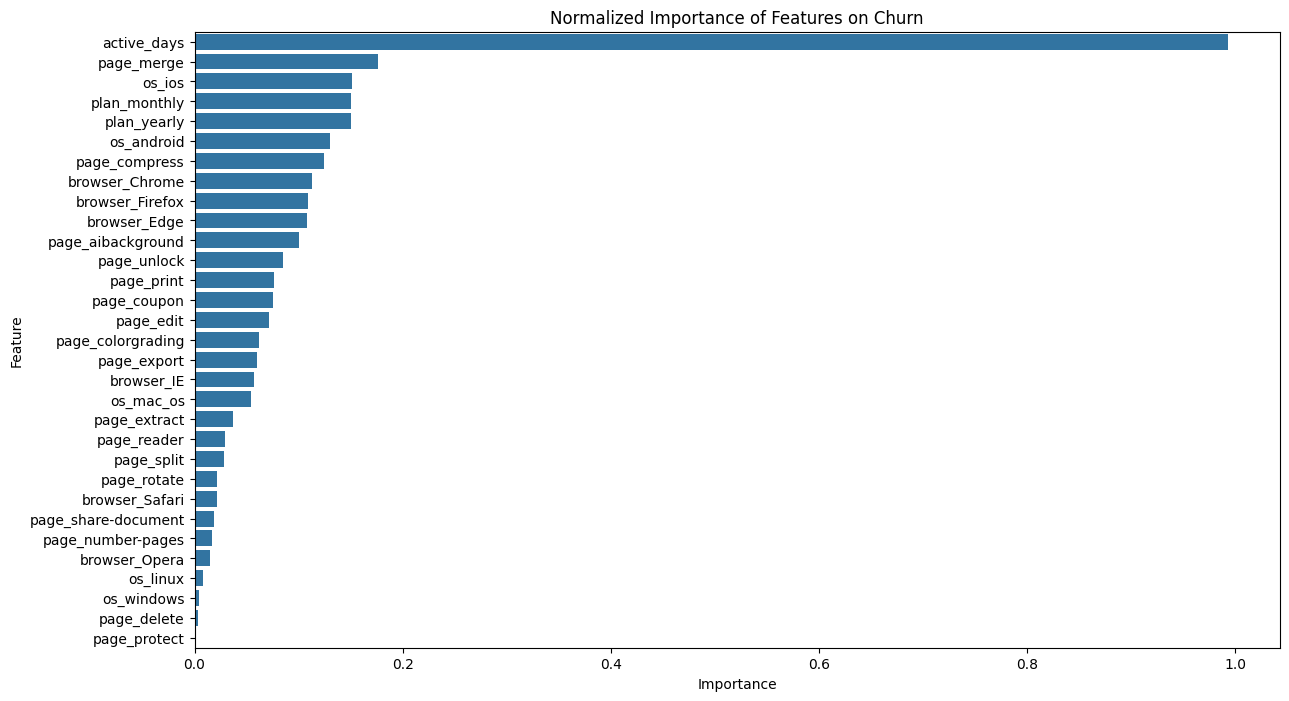

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a DataFrame
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')
df.dropna(inplace=True)

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the month and day from the timestamp
df['month'] = df['ts'].dt.to_period('M')
df['day'] = df['ts'].dt.day

# Identify the month each user first used the product
df['first_month'] = df.groupby('user_id')['month'].transform('min')

# Count the number of active days for each user in each month
active_days_per_user = df.groupby(['user_id', 'month'])['day'].nunique().reset_index()
active_days_per_user.columns = ['user_id', 'month', 'active_days']

# Merge with the first month information
active_days_per_user = active_days_per_user.merge(df[['user_id', 'first_month']].drop_duplicates(), on='user_id')

# Identify users who churned within the first month
active_days_per_user['next_month'] = active_days_per_user['month'] + 1
last_active_month = active_days_per_user.groupby('user_id')['month'].max().reset_index()
last_active_month.columns = ['user_id', 'last_active_month']
active_days_per_user = active_days_per_user.merge(last_active_month, on='user_id', how='left')
active_days_per_user['churned'] = (active_days_per_user['next_month'] > active_days_per_user['last_active_month']).astype(int)

# Filter for the first month data
first_month_data = active_days_per_user[active_days_per_user['month'] == active_days_per_user['first_month']]

# Merge with the original dataframe to get the OS, browser, plan, and page data
first_month_data = first_month_data.merge(df[['user_id', 'os', 'browser', 'plan', 'page']], on='user_id')

# One-hot encode the categorical variables
one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded_features = one_hot_encoder.fit_transform(first_month_data[['os', 'browser', 'plan', 'page']])
encoded_feature_names = one_hot_encoder.get_feature_names_out(['os', 'browser', 'plan', 'page'])

# Create a DataFrame with the encoded features
encoded_features_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Combine the encoded features with active days and churn status
first_month_data = first_month_data.reset_index(drop=True)
churn_data = pd.concat([encoded_features_df, first_month_data[['active_days', 'churned']]], axis=1)

# Define the features (X) and target (y)
X = churn_data.drop(columns=['churned'])
y = churn_data['churned']

# Create a pipeline with standard scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(max_iter=10000))
])

# Fit the model
pipeline.fit(X, y)

# Get the coefficients from the logistic regression model
coefficients = pipeline.named_steps['logistic'].coef_[0]

# Create a DataFrame for the coefficients
coeff_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# Calculate the absolute value of the coefficients to determine importance
coeff_df['Importance'] = coeff_df['Coefficient'].abs()

# Sort by importance
coeff_df = coeff_df.sort_values(by='Importance', ascending=False)

# Display the importance of each variable
print(coeff_df)

# Plot the importance
plt.figure(figsize=(14, 8))
sns.barplot(data=coeff_df, x='Importance', y='Feature')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Normalized Importance of Features on Churn')
plt.show()


  plan_category   churned
0       Monthly  0.277073
1        Yearly  0.186971


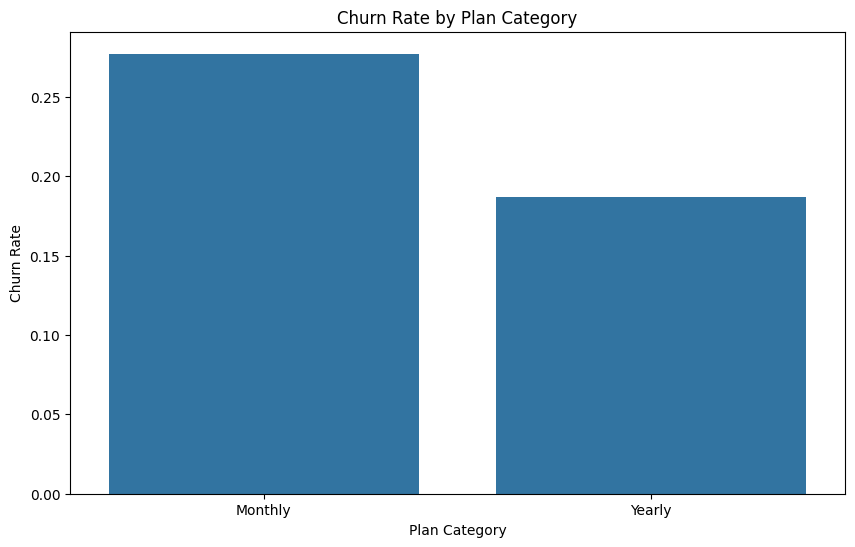

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')
df.dropna(inplace=True)

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the month from the timestamp
df['month'] = df['ts'].dt.to_period('M')

# Identify the month each user first used the product
df['first_month'] = df.groupby('user_id')['month'].transform('min')

# Count the number of active days for each user in each month
active_days_per_user = df.groupby(['user_id', 'month'])['ts'].nunique().reset_index()
active_days_per_user.columns = ['user_id', 'month', 'active_days']

# Merge with the first month information
active_days_per_user = active_days_per_user.merge(df[['user_id', 'first_month']].drop_duplicates(), on='user_id')

# Identify users who churned within the first month
active_days_per_user['next_month'] = active_days_per_user['month'] + 1
last_active_month = active_days_per_user.groupby('user_id')['month'].max().reset_index()
last_active_month.columns = ['user_id', 'last_active_month']
active_days_per_user = active_days_per_user.merge(last_active_month, on='user_id', how='left')
active_days_per_user['churned'] = (active_days_per_user['next_month'] > active_days_per_user['last_active_month']).astype(int)

# Filter for the first month data
first_month_data = active_days_per_user[active_days_per_user['month'] == active_days_per_user['first_month']]

# Merge with the original dataframe to get the plan data
first_month_data = first_month_data.merge(df[['user_id', 'plan']], on='user_id')

# Create a new column to categorize plans as 'Monthly' or 'Yearly'
def categorize_plan(plan):
    if 'monthly' in plan:
        return 'Monthly'
    elif 'yearly' in plan:
        return 'Yearly'
    else:
        return 'Other'

first_month_data['plan_category'] = first_month_data['plan'].apply(categorize_plan)

# Calculate churn rates for each plan category
churn_rate_by_plan = first_month_data.groupby('plan_category')['churned'].mean().reset_index()

# Display churn rates
print(churn_rate_by_plan)

# Plot churn rates
plt.figure(figsize=(10, 6))
sns.barplot(data=churn_rate_by_plan, x='plan_category', y='churned')
plt.xlabel('Plan Category')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Plan Category')
plt.show()


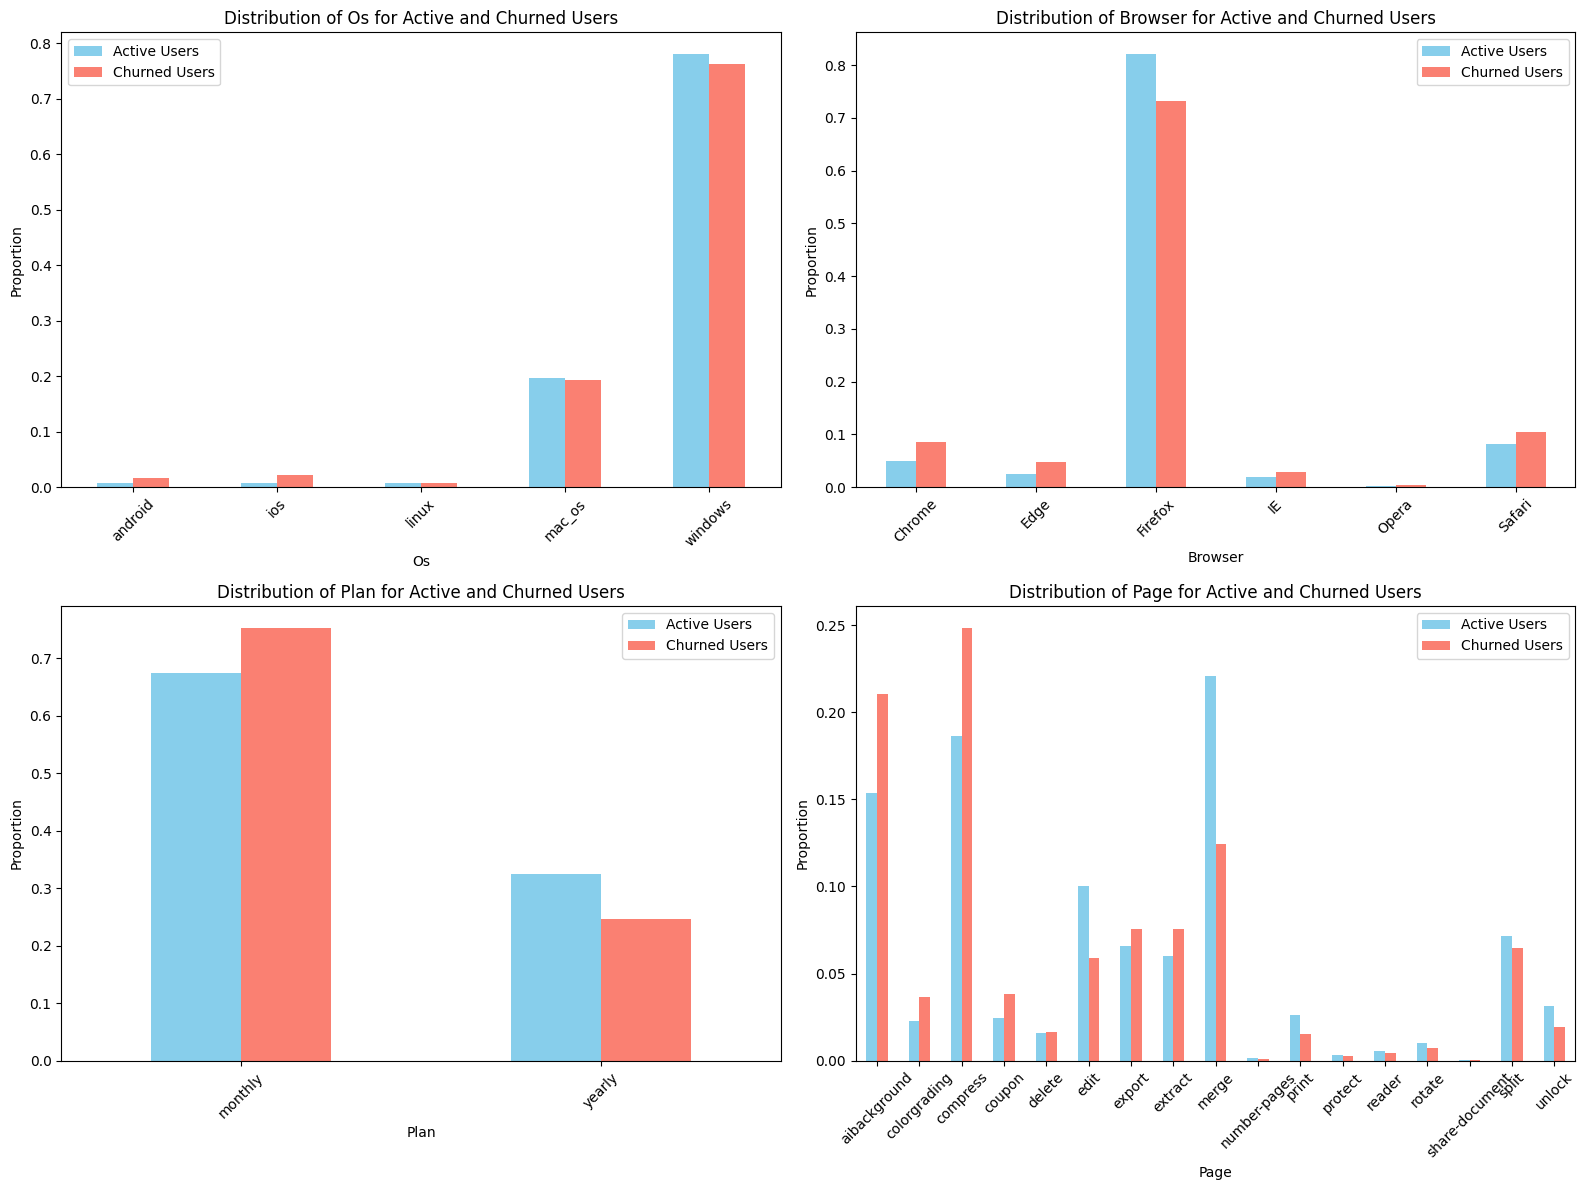

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a DataFrame
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')
df.dropna(inplace=True)

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the month from the timestamp
df['month'] = df['ts'].dt.to_period('M')

# Identify the month each user first used the product
df['first_month'] = df.groupby('user_id')['month'].transform('min')

# Count the number of active days for each user in each month
active_days_per_user = df.groupby(['user_id', 'month'])['ts'].nunique().reset_index()
active_days_per_user.columns = ['user_id', 'month', 'active_days']

# Merge with the first month information
active_days_per_user = active_days_per_user.merge(df[['user_id', 'first_month']].drop_duplicates(), on='user_id')

# Identify users who churned within the first month
active_days_per_user['next_month'] = active_days_per_user['month'] + 1
last_active_month = active_days_per_user.groupby('user_id')['month'].max().reset_index()
last_active_month.columns = ['user_id', 'last_active_month']
active_days_per_user = active_days_per_user.merge(last_active_month, on='user_id', how='left')
active_days_per_user['churned'] = (active_days_per_user['next_month'] > active_days_per_user['last_active_month']).astype(int)

# Filter for the first month data
first_month_data = active_days_per_user[active_days_per_user['month'] == active_days_per_user['first_month']]

# Filter users with more than 2.5 active days
active_users = first_month_data[first_month_data['active_days'] > 2.5]

# Identify churned users
churned_users = first_month_data[first_month_data['churned'] == 1]

# Merge with the original dataframe to get OS, plan, page, and browser data
active_users_data = active_users.merge(df[['user_id', 'os', 'browser', 'plan', 'page']], on='user_id')
churned_users_data = churned_users.merge(df[['user_id', 'os', 'browser', 'plan', 'page']], on='user_id')

# Plot bar plots for each feature
features = ['os', 'browser', 'plan', 'page']

plt.figure(figsize=(16, 12))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    active_count = active_users_data[feature].value_counts(normalize=True).sort_index()
    churned_count = churned_users_data[feature].value_counts(normalize=True).sort_index()
    plot_data = pd.DataFrame({'Active Users': active_count, 'Churned Users': churned_count}).fillna(0)
    plot_data.plot(kind='bar', ax=plt.gca(), color=['skyblue', 'salmon'])
    plt.title(f'Distribution of {feature.capitalize()} for Active and Churned Users')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


                     page_aibackground  page_colorgrading  page_compress  \
page_aibackground             1.000000          -0.068838      -0.212111   
page_colorgrading            -0.068838           1.000000      -0.075096   
page_compress                -0.212111          -0.075096       1.000000   
page_coupon                  -0.072297          -0.025596      -0.078868   
page_delete                  -0.055207          -0.019545      -0.060225   
page_edit                    -0.143383          -0.050763      -0.156416   
page_export                  -0.114913          -0.040684      -0.125358   
page_extract                 -0.115780          -0.040991      -0.126304   
page_merge                   -0.228778          -0.080996      -0.249573   
page_number-pages            -0.015739          -0.005572      -0.017170   
page_print                   -0.071551          -0.025332      -0.078055   
page_protect                 -0.023520          -0.008327      -0.025658   
page_reader 

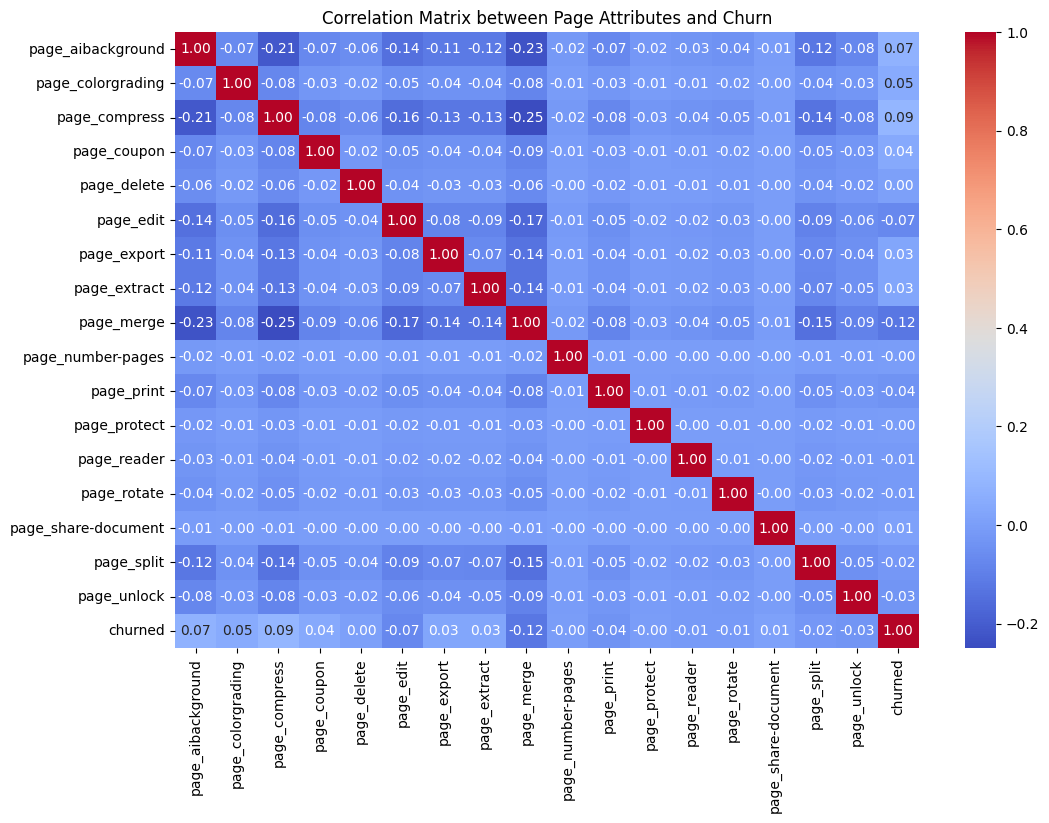

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Load the CSV file into a DataFrame
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')
df.dropna(inplace=True)

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the month from the timestamp
df['month'] = df['ts'].dt.to_period('M')

# Identify the month each user first used the product
df['first_month'] = df.groupby('user_id')['month'].transform('min')

# Count the number of active days for each user in each month
active_days_per_user = df.groupby(['user_id', 'month'])['ts'].nunique().reset_index()
active_days_per_user.columns = ['user_id', 'month', 'active_days']

# Merge with the first month information
active_days_per_user = active_days_per_user.merge(df[['user_id', 'first_month']].drop_duplicates(), on='user_id')

# Identify users who churned within the first month
active_days_per_user['next_month'] = active_days_per_user['month'] + 1
last_active_month = active_days_per_user.groupby('user_id')['month'].max().reset_index()
last_active_month.columns = ['user_id', 'last_active_month']
active_days_per_user = active_days_per_user.merge(last_active_month, on='user_id', how='left')
active_days_per_user['churned'] = (active_days_per_user['next_month'] > active_days_per_user['last_active_month']).astype(int)

# Filter for the first month data
first_month_data = active_days_per_user[active_days_per_user['month'] == active_days_per_user['first_month']]

# Merge with the original dataframe to get page data
first_month_data = first_month_data.merge(df[['user_id', 'page']], on='user_id')

# One-hot encode the page attributes
one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded_pages = one_hot_encoder.fit_transform(first_month_data[['page']])
encoded_page_names = one_hot_encoder.get_feature_names_out(['page'])

# Create a DataFrame with the encoded page attributes
encoded_pages_df = pd.DataFrame(encoded_pages, columns=encoded_page_names)

# Combine the encoded page attributes with the churn status
first_month_data = first_month_data.reset_index(drop=True)
page_churn_data = pd.concat([encoded_pages_df, first_month_data[['churned']]], axis=1)

# Calculate the correlation matrix
correlation_matrix = page_churn_data.corr()

# Print the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix between Page Attributes and Churn')
plt.show()


      month  DAU_MAU_ratio  average_DAU   MAU
0   2018-05     100.000000         1.00     1
1   2018-06     100.000000         1.00     1
2   2018-08      75.000000         1.50     2
3   2018-09     100.000000         1.00     1
4   2018-10     100.000000         1.00     1
5   2018-11     100.000000         1.00     1
6   2019-09      13.470588         2.29    17
7   2019-10      11.260870         2.59    23
8   2019-11      11.000000         3.30    30
9   2019-12       7.973684         3.03    38
10  2020-01       5.168182        22.74   440
11  2020-02       5.571912        32.93   591
12  2020-03       6.303781        48.35   767
13  2020-04       7.312249        72.83   996
14  2020-05       7.426335        80.65  1086
15  2020-06       7.723785        90.60  1173
16  2020-07       7.803136        89.58  1148
17  2020-08       7.405211        82.42  1113
18  2020-09       8.213158        93.63  1140
19  2020-10       7.670266        92.35  1204
20  2020-11       8.051502        

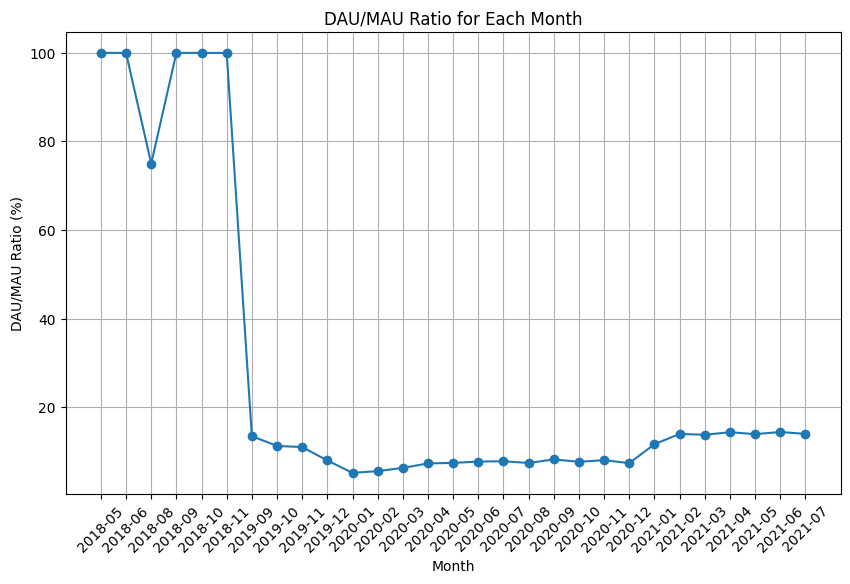

In [41]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the date and month from the timestamp
df['date'] = df['ts'].dt.date
df['month'] = df['ts'].dt.to_period('M')

# Calculate DAU (Daily Active Users)
dau = df.groupby('date')['user_id'].nunique().reset_index()
dau.columns = ['date', 'DAU']

# Calculate MAU (Monthly Active Users)
mau = df.groupby('month')['user_id'].nunique().reset_index()
mau.columns = ['month', 'MAU']

# Merge DAU with the month
dau['month'] = pd.to_datetime(dau['date']).dt.to_period('M')

# Calculate the average DAU for each month
average_dau = round(dau.groupby('month')['DAU'].mean().reset_index(),2)
average_dau.columns = ['month', 'average_DAU']

# Merge the average DAU with MAU
dau_mau = pd.merge(average_dau, mau, on='month')

# Calculate the DAU/MAU ratio
dau_mau['DAU_MAU_ratio'] = (dau_mau['average_DAU'] / dau_mau['MAU']) * 100

# Display the DAU/MAU ratio for each month
print(dau_mau[['month', 'DAU_MAU_ratio','average_DAU','MAU']])
import matplotlib.pyplot as plt

# Plot DAU/MAU ratio for each month
plt.figure(figsize=(10, 6))
plt.plot(dau_mau['month'].astype(str), dau_mau['DAU_MAU_ratio'], marker='o')
plt.xlabel('Month')
plt.ylabel('DAU/MAU Ratio (%)')
plt.title('DAU/MAU Ratio for Each Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

      month  WAU_MAU_ratio
0   2018-05     100.000000
1   2018-06     100.000000
2   2018-08      75.000000
3   2018-09     100.000000
4   2018-10     100.000000
5   2018-11     100.000000
6   2019-09      35.294118
7   2019-10      44.565217
8   2019-11      41.666667
9   2019-12      60.526316
10  2020-01      29.659091
11  2020-02      30.456853
12  2020-03      31.342894
13  2020-04      33.584337
14  2020-05      34.599448
15  2020-06      35.208866
16  2020-07      33.689024
17  2020-08      34.932615
18  2020-09      35.767544
19  2020-10      36.544850
20  2020-11      38.094421
21  2020-12      31.340734
22  2021-01      50.049900
23  2021-02      53.770302
24  2021-03      50.189573
25  2021-04      54.805195
26  2021-05      54.111111
27  2021-06      52.173913
28  2021-07      43.884892


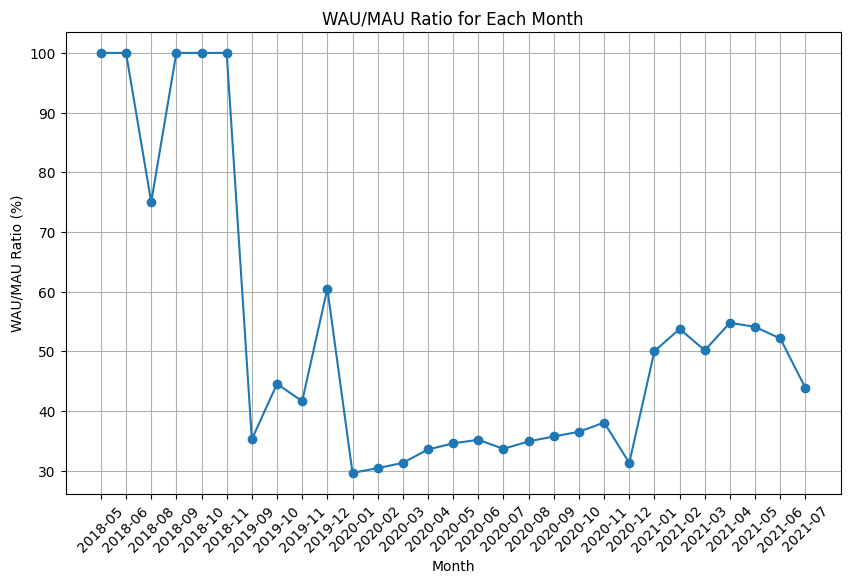

In [43]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the week and month from the timestamp
df['week'] = df['ts'].dt.to_period('W')
df['month'] = df['ts'].dt.to_period('M')

# Calculate WAU (Weekly Active Users)
wau = df.groupby('week')['user_id'].nunique().reset_index()
wau.columns = ['week', 'WAU']

# Calculate MAU (Monthly Active Users)
mau = df.groupby('month')['user_id'].nunique().reset_index()
mau.columns = ['month', 'MAU']

# Extract month from the week period
wau['month'] = wau['week'].apply(lambda x: x.start_time.to_period('M'))

# Calculate the average WAU for each month
average_wau = wau.groupby('month')['WAU'].mean().reset_index()
average_wau.columns = ['month', 'average_WAU']

# Merge the average WAU with MAU
wau_mau = pd.merge(average_wau, mau, on='month')

# Calculate the WAU/MAU ratio
wau_mau['WAU_MAU_ratio'] = (wau_mau['average_WAU'] / wau_mau['MAU']) * 100

# Display the WAU/MAU ratio for each month
print(wau_mau[['month', 'WAU_MAU_ratio']])

# Plot WAU/MAU ratio for each month
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(wau_mau['month'].astype(str), wau_mau['WAU_MAU_ratio'], marker='o')
plt.xlabel('Month')
plt.ylabel('WAU/MAU Ratio (%)')
plt.title('WAU/MAU Ratio for Each Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


        month  average_DAU  average_WAU  DAU_to_WAU_ratio
0  2018-05-01     1.000000         1.00          1.000000
1  2018-06-01     1.000000         1.00          1.000000
2  2018-08-01     1.500000         1.50          1.000000
3  2018-09-01     1.000000         1.00          1.000000
4  2018-10-01     1.000000         1.00          1.000000
5  2018-11-01     1.000000         1.00          1.000000
6  2019-09-01     2.285714         6.00          0.380952
7  2019-10-01     2.592593        10.25          0.252936
8  2019-11-01     3.296296        12.50          0.263704
9  2019-12-01     3.032258        23.00          0.131837
10 2020-01-01    22.741935       130.50          0.174268
11 2020-02-01    32.931034       180.00          0.182950
12 2020-03-01    48.354839       240.40          0.201143
13 2020-04-01    72.833333       334.50          0.217738
14 2020-05-01    80.645161       375.75          0.214625
15 2020-06-01    90.600000       413.00          0.219370
16 2020-07-01 

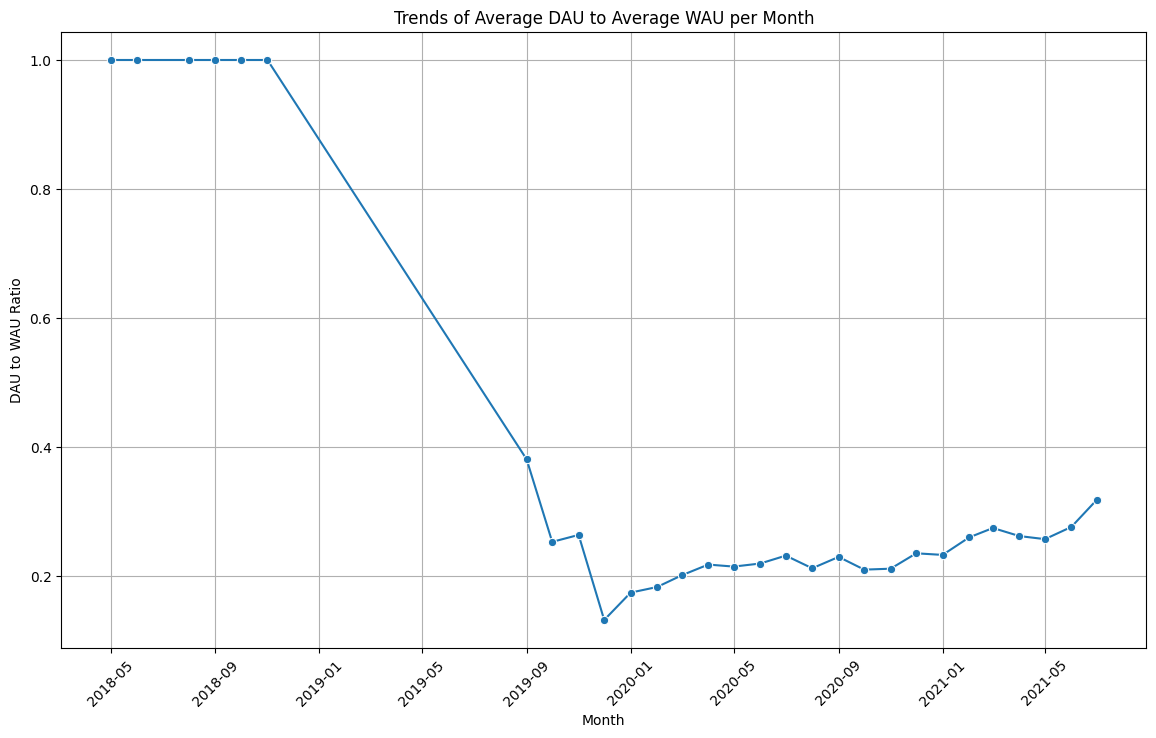

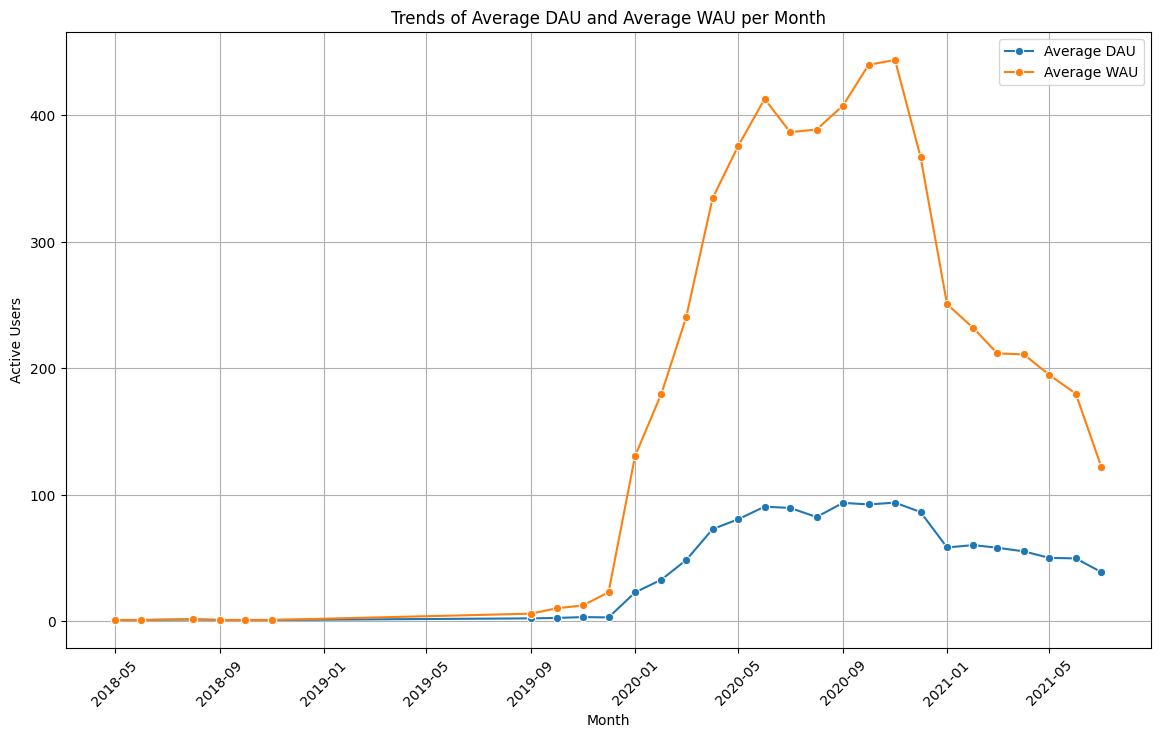

In [93]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the date, week, and month from the timestamp
df['date'] = df['ts'].dt.date
df['week'] = df['ts'].dt.to_period('W').apply(lambda r: r.start_time)
df['month'] = df['ts'].dt.to_period('M').apply(lambda r: r.start_time)

# Calculate DAU (Daily Active Users)
dau = df.groupby('date')['user_id'].nunique().reset_index()
dau.columns = ['date', 'DAU']
dau['month'] = pd.to_datetime(dau['date']).dt.to_period('M').apply(lambda r: r.start_time)

# Calculate WAU (Weekly Active Users)
wau = df.groupby('week')['user_id'].nunique().reset_index()
wau.columns = ['week', 'WAU']
wau['month'] = pd.to_datetime(wau['week']).dt.to_period('M').apply(lambda r: r.start_time)

# Calculate the average DAU for each month
monthly_dau = dau.groupby('month')['DAU'].mean().reset_index()
monthly_dau.columns = ['month', 'average_DAU']

# Calculate the average WAU for each month
monthly_wau = wau.groupby('month')['WAU'].mean().reset_index()
monthly_wau.columns = ['month', 'average_WAU']
# Merge monthly DAU and WAU
monthly_metrics = pd.merge(monthly_dau, monthly_wau, on='month')

# Calculate the ratio of average DAU to average WAU
monthly_metrics['DAU_to_WAU_ratio'] = monthly_metrics['average_DAU'] / monthly_metrics['average_WAU']

# Display the result
print(monthly_metrics)
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the trends
plt.figure(figsize=(14, 8))
sns.lineplot(data=monthly_metrics, x='month', y='DAU_to_WAU_ratio', marker='o')
plt.xlabel('Month')
plt.ylabel('DAU to WAU Ratio')
plt.title('Trends of Average DAU to Average WAU per Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot DAU and WAU trends
plt.figure(figsize=(14, 8))
sns.lineplot(data=monthly_metrics, x='month', y='average_DAU', marker='o', label='Average DAU')
sns.lineplot(data=monthly_metrics, x='month', y='average_WAU', marker='o', label='Average WAU')
plt.xlabel('Month')
plt.ylabel('Active Users')
plt.title('Trends of Average DAU and Average WAU per Month')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


              page  average_count_per_week
8            merge              384.670330
2         compress              297.125000
0     aibackground              270.898990
5             edit              172.021739
15           split              138.670455
7          extract              110.989691
6           export              105.838384
16          unlock               55.200000
10           print               49.623529
3           coupon               47.833333
1     colorgrading               42.075269
4           delete               30.807229
13          rotate               19.839506
12          reader               14.400000
11         protect                7.915254
9     number-pages                4.265306
14  share-document                2.583333


/var/folders/wx/9n292s155d122llxsys0ml2h0000gn/T/ipykernel_25415/3079209054.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_tasks_per_week, x='average_count_per_week', y='page', palette='viridis')


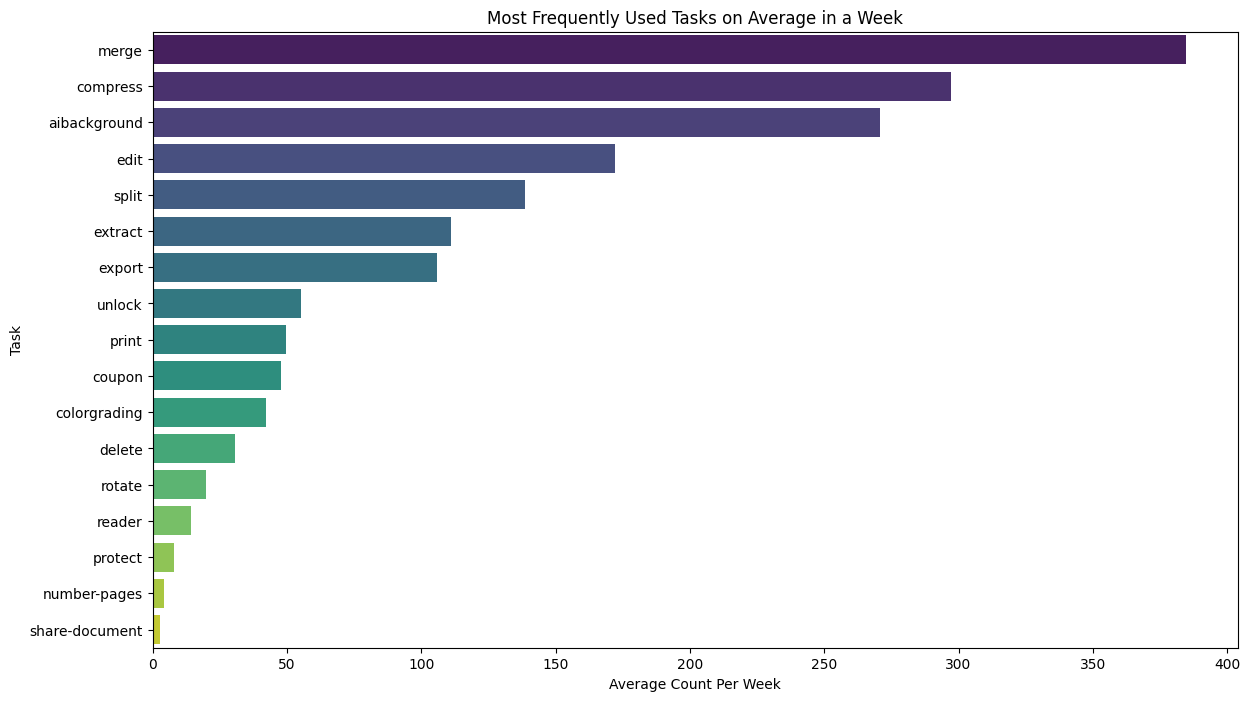

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the week from the timestamp
df['week'] = df['ts'].dt.to_period('W')

# Calculate the number of tasks performed each week
tasks_per_week = df.groupby(['week', 'page']).size().reset_index(name='count')

# Calculate the average frequency of each task per week
average_tasks_per_week = tasks_per_week.groupby('page')['count'].mean().reset_index()
average_tasks_per_week.columns = ['page', 'average_count_per_week']

# Sort by the most frequently used tasks
average_tasks_per_week = average_tasks_per_week.sort_values(by='average_count_per_week', ascending=False)

# Display the most frequently used tasks
print(average_tasks_per_week)

# Plot the most frequently used tasks
plt.figure(figsize=(14, 8))
sns.barplot(data=average_tasks_per_week, x='average_count_per_week', y='page', palette='viridis')
plt.xlabel('Average Count Per Week')
plt.ylabel('Task')
plt.title('Most Frequently Used Tasks on Average in a Week')
plt.show()


      month  overall_avg_task_count  average_DAU
0   2018-05                3.000000     1.000000
1   2018-06                1.000000     1.000000
2   2018-08                2.000000     1.500000
3   2018-09                1.250000     1.000000
4   2018-10                1.000000     1.000000
5   2018-11                1.000000     1.000000
6   2019-09                2.075630     2.285714
7   2019-10                1.934420     2.592593
8   2019-11                2.030519     3.296296
9   2019-12                1.712260     3.032258
10  2020-01                3.361225    22.741935
11  2020-02                3.906099    32.931034
12  2020-03                3.888613    48.354839
13  2020-04                3.960220    72.833333
14  2020-05                4.181086    80.645161
15  2020-06                4.017554    90.600000
16  2020-07                4.156496    89.580645
17  2020-08                4.229518    82.419355
18  2020-09                3.848844    93.633333
19  2020-10         

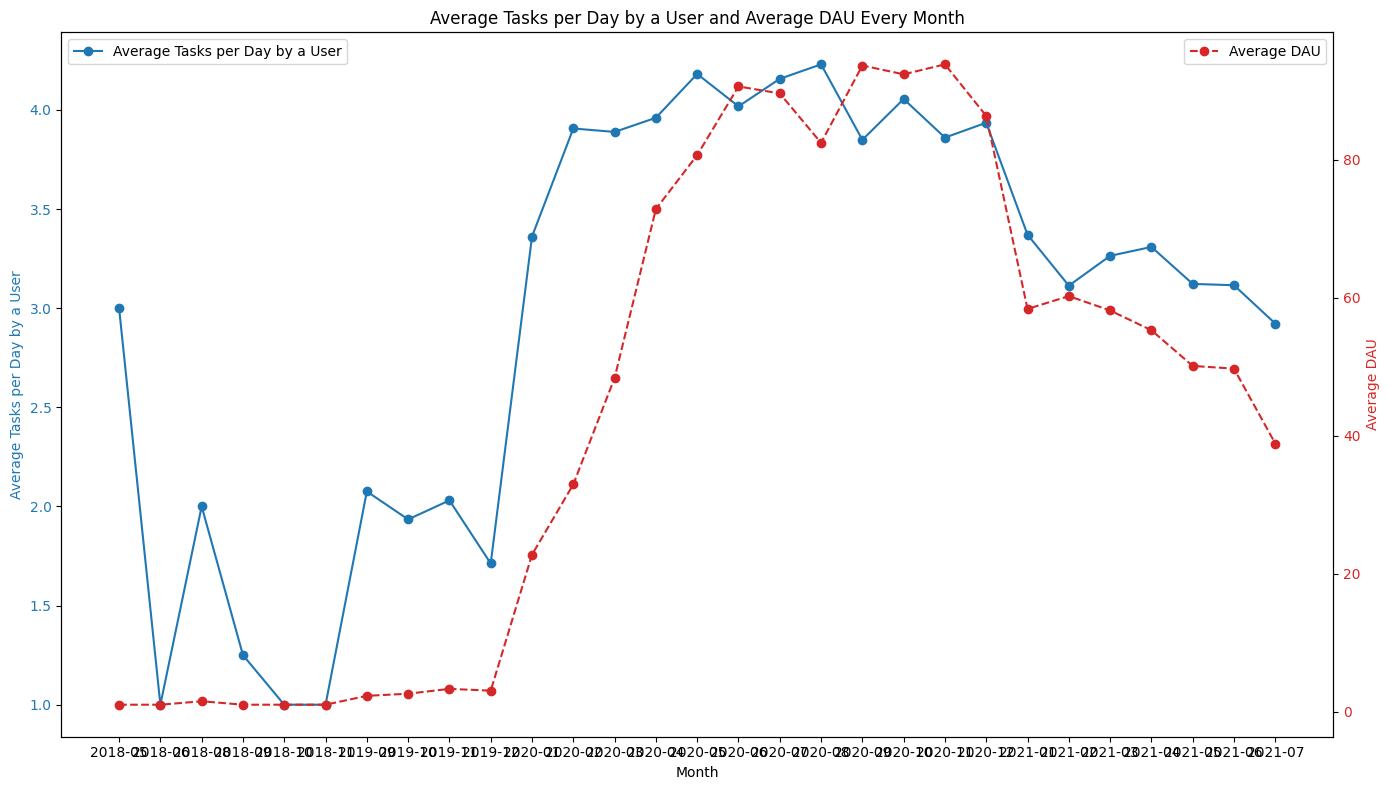

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the month and date from the timestamp
df['month'] = df['ts'].dt.to_period('M')
df['date'] = df['ts'].dt.date

# Group by user, date, and month to count the number of tasks completed each day
user_day_tasks = df.groupby(['user_id', 'date', 'month']).size().reset_index(name='task_count')

# Calculate the average number of tasks completed per day by each user every month
avg_tasks_per_day = user_day_tasks.groupby(['user_id', 'month'])['task_count'].mean().reset_index()
avg_tasks_per_day.columns = ['user_id', 'month', 'avg_task_count']

# Calculate the overall average number of tasks completed per day every month
overall_avg_tasks_per_day = avg_tasks_per_day.groupby('month')['avg_task_count'].mean().reset_index()
overall_avg_tasks_per_day.columns = ['month', 'overall_avg_task_count']

# Calculate DAU (Daily Active Users)
dau = df.groupby('date')['user_id'].nunique().reset_index()
dau.columns = ['date', 'DAU']
dau['month'] = pd.to_datetime(dau['date']).dt.to_period('M')

# Calculate the average DAU for each month
average_dau_per_month = dau.groupby('month')['DAU'].mean().reset_index()
average_dau_per_month.columns = ['month', 'average_DAU']

# Merge the average tasks and average DAU data for visualization
task_dau_stats_per_month = pd.merge(overall_avg_tasks_per_day, average_dau_per_month, on='month')

# Display the average number of tasks and the average DAU every month
print(task_dau_stats_per_month)

# Plot the average number of tasks completed per day and the average DAU every month
fig, ax1 = plt.subplots(figsize=(14, 8))

color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Tasks per Day by a User', color=color)
ax1.plot(task_dau_stats_per_month['month'].astype(str), task_dau_stats_per_month['overall_avg_task_count'], marker='o', color=color, label='Average Tasks per Day by a User')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average DAU', color=color)
ax2.plot(task_dau_stats_per_month['month'].astype(str), task_dau_stats_per_month['average_DAU'], marker='o', linestyle='--', color=color, label='Average DAU')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Average Tasks per Day by a User and Average DAU Every Month')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [58]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the date from the timestamp
df['date'] = df['ts'].dt.date

# Group by date and task (page) to count the number of tasks completed each day
daily_task_counts = df.groupby(['date', 'page']).size().reset_index(name='count')

# Define a function to get the most used task for each day
def get_most_used_task(group):
    return group.loc[group['count'].idxmax()]

# Apply the function to get the most used task for each day
print(daily_task_counts)


            date          page  count
0     2018-05-25        coupon      1
1     2018-05-25         split      2
2     2018-06-05        coupon      1
3     2018-08-24      compress      2
4     2018-08-29      compress      2
...          ...           ...    ...
7260  2021-07-26  number-pages      2
7261  2021-07-26         print      3
7262  2021-07-26        reader      1
7263  2021-07-26         split     10
7264  2021-07-26        unlock      1

[7265 rows x 3 columns]


              Task  Importance
12          reader    0.472378
16          unlock    0.385202
0     aibackground    0.360030
6           export    0.180662
15           split    0.174562
10           print    0.148908
2         compress    0.144768
3           coupon    0.139497
4           delete    0.120263
11         protect    0.077851
8            merge    0.051845
9     number-pages    0.042581
7          extract    0.023640
5             edit    0.003169
13          rotate   -0.085803
1     colorgrading   -0.138537
14  share-document  -18.802767


/var/folders/wx/9n292s155d122llxsys0ml2h0000gn/T/ipykernel_25415/2838636418.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coefficients, x='Importance', y='Task', palette='viridis')


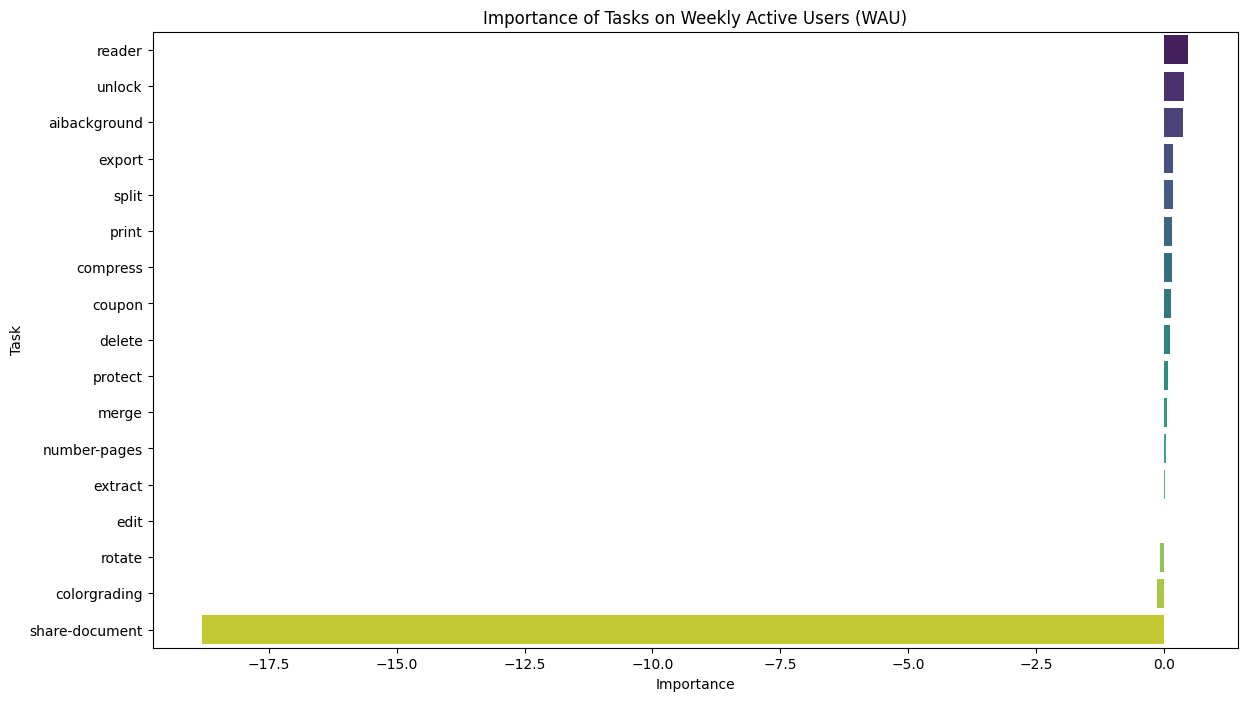

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the week from the timestamp
df['week'] = df['ts'].dt.to_period('W')

# Calculate the number of tasks performed each week
tasks_per_week = df.groupby(['week', 'page']).size().reset_index(name='count')

# Calculate WAU (Weekly Active Users)
wau = df.groupby('week')['user_id'].nunique().reset_index()
wau.columns = ['week', 'WAU']

# Convert 'week' from Period to string for merging
tasks_per_week['week'] = tasks_per_week['week'].astype(str)
wau['week'] = wau['week'].astype(str)

# Merge the tasks data with WAU
tasks_wau = pd.merge(tasks_per_week, wau, on='week')

# Pivot the data to create a matrix of tasks counts per week
task_matrix = tasks_wau.pivot_table(index='week', columns='page', values='count', fill_value=0)

# Merge the task matrix with WAU
task_wau_matrix = pd.merge(task_matrix, wau, on='week')

# Prepare data for regression
X = task_wau_matrix.drop(columns=['WAU', 'week'])
y = task_wau_matrix['WAU']

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the coefficients
coefficients = pd.DataFrame({'Task': X.columns, 'Importance': model.coef_})

# Sort the coefficients by importance
coefficients = coefficients.sort_values(by='Importance', ascending=False)

# Display the task importance
print(coefficients)

# Visualize the task importance
plt.figure(figsize=(14, 8))
sns.barplot(data=coefficients, x='Importance', y='Task', palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Task')
plt.title('Importance of Tasks on Weekly Active Users (WAU)')
plt.show()


aibackground      0.939908
compress          0.900425
export            0.853671
merge             0.853469
edit              0.836560
split             0.827162
extract           0.821017
unlock            0.766466
colorgrading      0.746525
coupon            0.725418
print             0.714340
delete            0.541750
rotate            0.445475
share-document    0.349677
reader            0.293890
protect           0.282466
number-pages      0.245024
Name: WAU, dtype: float64


/var/folders/wx/9n292s155d122llxsys0ml2h0000gn/T/ipykernel_25415/1958514876.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=task_correlation.values, y=task_correlation.index, palette='viridis')


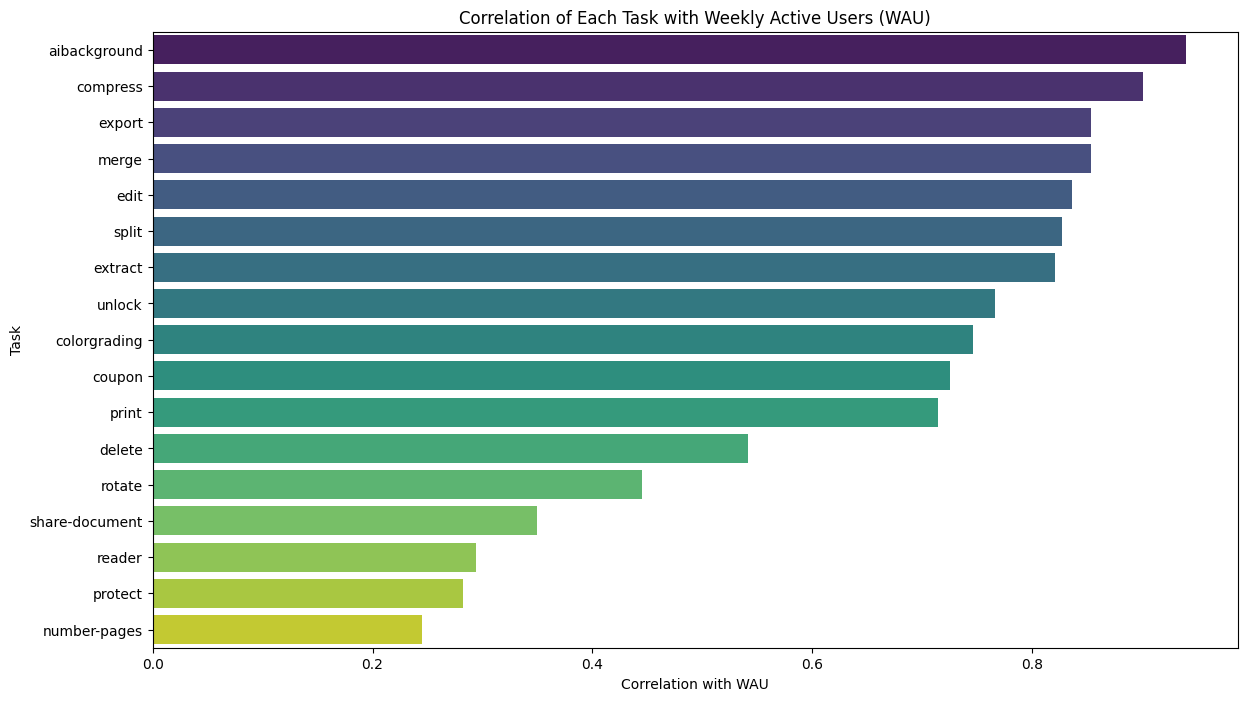

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the week from the timestamp
df['week'] = df['ts'].dt.to_period('W')

# Calculate the number of tasks performed each week
tasks_per_week = df.groupby(['week', 'page']).size().reset_index(name='count')

# Calculate WAU (Weekly Active Users)
wau = df.groupby('week')['user_id'].nunique().reset_index()
wau.columns = ['week', 'WAU']

# Convert 'week' from Period to string for merging
tasks_per_week['week'] = tasks_per_week['week'].astype(str)
wau['week'] = wau['week'].astype(str)

# Pivot the data to create a matrix of tasks counts per week
task_matrix = tasks_per_week.pivot_table(index='week', columns='page', values='count', fill_value=0)

# Merge the task matrix with WAU
task_wau_matrix = pd.merge(task_matrix, wau, on='week')

# Ensure all data is numeric (drop the 'week' column before calculating correlation)
task_wau_matrix_numeric = task_wau_matrix.drop(columns=['week'])

# Calculate the correlation matrix
correlation_matrix = task_wau_matrix_numeric.corr()

# Extract the correlations of each task with WAU
task_correlation = correlation_matrix['WAU'].drop('WAU').sort_values(ascending=False)

# Display the correlations
print(task_correlation)

# Visualize the correlations
plt.figure(figsize=(14, 8))
sns.barplot(x=task_correlation.values, y=task_correlation.index, palette='viridis')
plt.xlabel('Correlation with WAU')
plt.ylabel('Task')
plt.title('Correlation of Each Task with Weekly Active Users (WAU)')
plt.show()


In [63]:
import pandas as pd
import statsmodels.api as sm

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the week from the timestamp
df['week'] = df['ts'].dt.to_period('W')

# Calculate the number of tasks performed each week
tasks_per_week = df.groupby(['week', 'page']).size().reset_index(name='count')

# Calculate WAU (Weekly Active Users)
wau = df.groupby('week')['user_id'].nunique().reset_index()
wau.columns = ['week', 'WAU']

# Convert 'week' from Period to string for merging
tasks_per_week['week'] = tasks_per_week['week'].astype(str)
wau['week'] = wau['week'].astype(str)

# Pivot the data to create a matrix of tasks counts per week
task_matrix = tasks_per_week.pivot_table(index='week', columns='page', values='count', fill_value=0)

# Merge the task matrix with WAU
task_wau_matrix = pd.merge(task_matrix, wau, on='week')

# Select the specified tasks and the WAU
tasks_of_interest = ['aibackground', 'compress', 'export', 'merge', 'edit']
X = task_wau_matrix[tasks_of_interest]
y = task_wau_matrix['WAU']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Perform the regression analysis
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    WAU   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     414.0
Date:                Thu, 25 Jul 2024   Prob (F-statistic):           4.80e-66
Time:                        18:17:35   Log-Likelihood:                -532.77
No. Observations:                 108   AIC:                             1078.
Df Residuals:                     102   BIC:                             1094.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           21.1733      5.678      3.729   

                            OLS Regression Results                            
Dep. Variable:                    WAU   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     127.1
Date:                Thu, 25 Jul 2024   Prob (F-statistic):           2.59e-55
Time:                        18:26:02   Log-Likelihood:                -499.07
No. Observations:                 108   AIC:                             1050.
Df Residuals:                      82   BIC:                             1120.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

/var/folders/wx/9n292s155d122llxsys0ml2h0000gn/T/ipykernel_25415/1652222105.py:59: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='coef', y=conf_int.index, data=conf_int, palette='viridis', ci=None)
/var/folders/wx/9n292s155d122llxsys0ml2h0000gn/T/ipykernel_25415/1652222105.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coef', y=conf_int.index, data=conf_int, palette='viridis', ci=None)


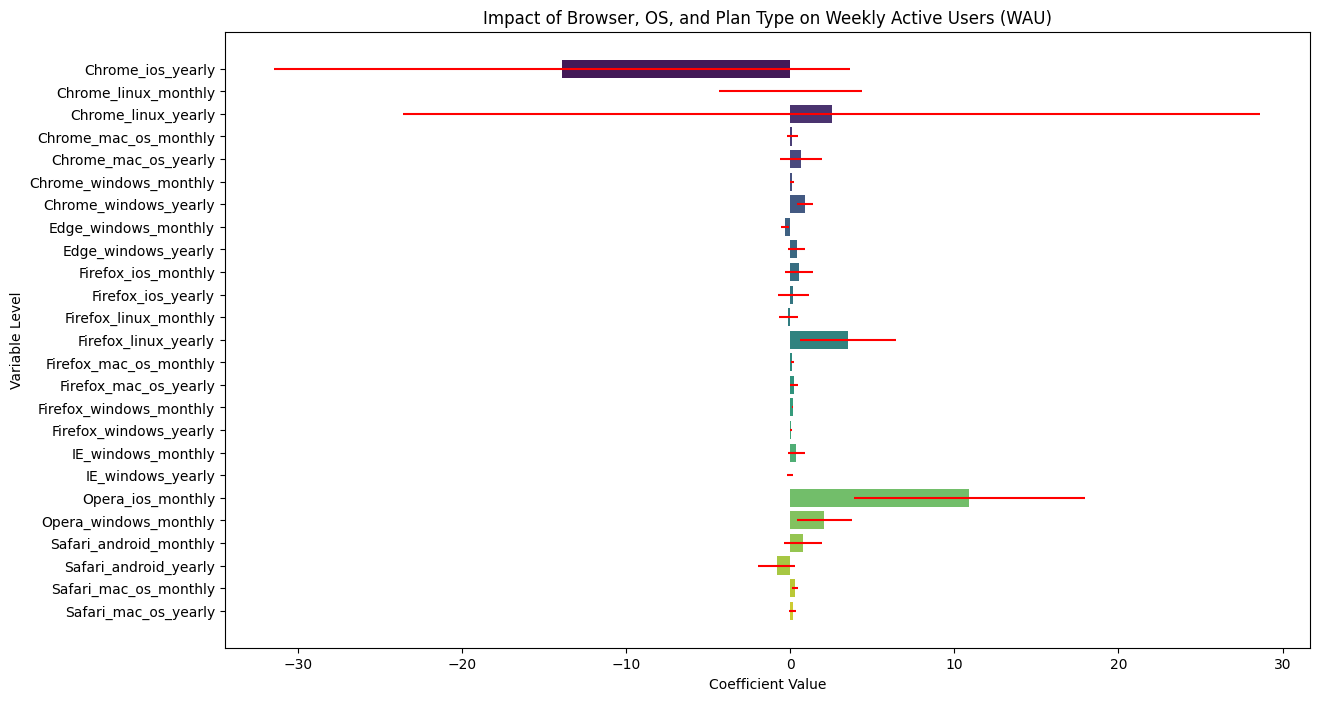

In [70]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the week from the timestamp
df['week'] = df['ts'].dt.to_period('W').astype(str)

# Calculate WAU (Weekly Active Users)
wau = df.groupby('week')['user_id'].nunique().reset_index()
wau.columns = ['week', 'WAU']

# Aggregate data by week, browser, os, and plan
agg_data = df.groupby(['week', 'browser', 'os', 'plan']).size().reset_index(name='task_count')

# Pivot the data to create a matrix
task_matrix = agg_data.pivot_table(index='week', columns=['browser', 'os', 'plan'], values='task_count', fill_value=0)

# Flatten the multi-level columns
task_matrix.columns = ['_'.join(col).strip() for col in task_matrix.columns.values]

# Reset index to prepare for merge
task_matrix.reset_index(inplace=True)

# Merge the task matrix with WAU
task_wau_matrix = pd.merge(task_matrix, wau, on='week')

# Prepare the data for regression
X = task_wau_matrix.drop(columns=['week', 'WAU'])
y = task_wau_matrix['WAU']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Perform the regression analysis
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

import matplotlib.pyplot as plt
import seaborn as sns

# Extract coefficients and confidence intervals
coefficients = model.params
conf_int = model.conf_int()
conf_int['coef'] = coefficients

# Filter out the constant term
conf_int = conf_int.loc[conf_int.index != 'const']

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x='coef', y=conf_int.index, data=conf_int, palette='viridis', ci=None)
plt.errorbar(x=conf_int['coef'], y=conf_int.index, xerr=(conf_int[1] - conf_int['coef']), fmt='none', c='red')
plt.xlabel('Coefficient Value')
plt.ylabel('Variable Level')
plt.title('Impact of Browser, OS, and Plan Type on Weekly Active Users (WAU)')
plt.show()



In [96]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the week from the timestamp
df['week'] = df['ts'].dt.to_period('W')

# Calculate WAU (Weekly Active Users)
wau = df.groupby('week')['user_id'].nunique().reset_index()
wau.columns = ['week', 'WAU']

# Merge WAU back to the main dataframe
df = pd.merge(df, wau, on='week')

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['browser', 'os', 'page', 'plan'], drop_first=True)

# Check for missing values and handle them (if any)
df_encoded = df_encoded.dropna()

# Ensure all data is numeric
df_encoded = df_encoded.apply(pd.to_numeric, errors='coerce')
df_encoded = df_encoded.dropna()

# Display the first few rows to verify
print(df_encoded.head())
import statsmodels.api as sm

# Prepare the independent variables (X) and dependent variable (y)
# We drop the 'ts', 'user_id', 'week', and any other non-feature columns
X = df_encoded.drop(columns=['ts', 'user_id', 'week', 'WAU'])
y = df_encoded['WAU']

# Add a constant to the independent variables (intercept term)
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Display the summary of the regression model
print(model.summary())
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the coefficients and their confidence intervals
coefficients = model.params
conf_int = model.conf_int()
conf_int['coef'] = coefficients

# Filter out the intercept
conf_int = conf_int.drop(index='const')

# Create a DataFrame for plotting
plot_data = conf_int.reset_index()
plot_data.columns = ['Term', 'CI Lower', 'CI Upper', 'Coefficient']

# Sort the terms for better visualization
plot_data = plot_data.sort_values(by='Coefficient', ascending=False)

# Plot the coefficients
plt.figure(figsize=(14, 8))
sns.barplot(x='Coefficient', y='Term', data=plot_data, palette='viridis')
plt.errorbar(plot_data['Coefficient'], plot_data['Term'], 
             xerr=[plot_data['Coefficient'] - plot_data['CI Lower'], plot_data['CI Upper'] - plot_data['Coefficient']], 
             fmt='none', c='black', capsize=5)

plt.xlabel('Coefficient')
plt.ylabel('Term')
plt.title('Regression Coefficients for Predicting WAU')
plt.grid(True)
plt.show()


Empty DataFrame
Columns: [Unnamed: 0, ts, user_id, week, WAU, browser_Edge, browser_Firefox, browser_IE, browser_Opera, browser_Safari, os_ios, os_linux, os_mac_os, os_windows, page_colorgrading, page_compress, page_coupon, page_delete, page_edit, page_export, page_extract, page_merge, page_number-pages, page_print, page_protect, page_reader, page_rotate, page_share-document, page_split, page_unlock, plan_yearly]
Index: []

[0 rows x 31 columns]


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Assuming the regression model is already fitted and named as 'model'

# Extract the coefficients and their confidence intervals
coefficients = model.params
conf_int = model.conf_int()
conf_int['coef'] = coefficients

# Filter out the intercept
conf_int = conf_int.drop(index='Intercept')

# Create a DataFrame for plotting
plot_data = conf_int.reset_index()
plot_data.columns = ['Term', 'CI Lower', 'CI Upper', 'Coefficient']

# Sort the terms for better visualization
plot_data = plot_data.sort_values(by='Coefficient', ascending=False)

# Plot the coefficients
plt.figure(figsize=(14, 8))
sns.barplot(x='Coefficient', y='Term', data=plot_data, palette='viridis')
plt.errorbar(plot_data['Coefficient'], plot_data['Term'], 
             xerr=[plot_data['Coefficient'] - plot_data['CI Lower'], plot_data['CI Upper'] - plot_data['Coefficient']], 
             fmt='none', c='black', capsize=5)

plt.xlabel('Coefficient')
plt.ylabel('Term')
plt.title('Regression Coefficients for Predicting WAU')
plt.grid(True)
plt.show()


KeyError: "['Intercept'] not found in axis"

In [74]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the week from the timestamp
df['week'] = df['ts'].dt.to_period('W').astype(str)

# Calculate WAU (Weekly Active Users)
wau_total = df.groupby('week')['user_id'].nunique().reset_index()
wau_total.columns = ['week', 'total_WAU']

# Aggregate data by week, browser, os, and plan
agg_data = df.groupby(['week', 'browser', 'os', 'plan']).size().reset_index(name='task_count')

# Calculate WAU for each combination of browser, os, and plan
wau_combination = df.groupby(['week', 'browser', 'os', 'plan'])['user_id'].nunique().reset_index()
wau_combination.columns = ['week', 'browser', 'os', 'plan', 'combination_WAU']

# Merge the total WAU with the combination WAU
wau_combined = pd.merge(wau_combination, wau_total, on='week', how='left').fillna(0)

# Calculate the percentage of WAUs for each combination
wau_combined['percentage'] = (wau_combined['combination_WAU'] / wau_combined['total_WAU']) * 100

# Pivot the data to create a matrix for regression analysis
task_matrix = wau_combined.pivot_table(index='week', columns=['browser', 'os', 'plan'], values='combination_WAU', fill_value=0)

# Flatten the multi-level columns
task_matrix.columns = ['_'.join(col).strip() for col in task_matrix.columns.values]

# Reset index to prepare for merge
task_matrix.reset_index(inplace=True)

# Merge the task matrix with total WAU
task_wau_matrix = pd.merge(task_matrix, wau_total, on='week')

# Prepare the data for regression
X = task_wau_matrix.drop(columns=['week', 'total_WAU'])
y = task_wau_matrix['total_WAU']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add a constant to the model (intercept)
X_scaled = sm.add_constant(X_scaled)

# Perform the regression analysis
model = sm.OLS(y, X_scaled).fit()

# Print the summary of the regression model
print(model.summary())

# Display the WAU percentages for each combination
print(wau_combined[['week', 'browser', 'os', 'plan', 'combination_WAU', 'total_WAU', 'percentage']])

# Calculate the average percentage for each combination
average_percentage_combination = wau_combined.groupby(['browser', 'os', 'plan'])['percentage'].mean().reset_index()
average_percentage_combination.columns = ['browser', 'os', 'plan', 'average_percentage']

# Display the average WAU percentage for each combination
print(average_percentage_combination)


                            OLS Regression Results                            
Dep. Variable:              total_WAU   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.556e+04
Date:                Thu, 25 Jul 2024   Prob (F-statistic):          2.39e-140
Time:                        18:32:18   Log-Likelihood:                -240.81
No. Observations:                 108   AIC:                             533.6
Df Residuals:                      82   BIC:                             603.4
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        223.8333      0.248    900.950      0.0

                            OLS Regression Results                            
Dep. Variable:                    WAU   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     127.1
Date:                Fri, 26 Jul 2024   Prob (F-statistic):           2.59e-55
Time:                        00:48:08   Log-Likelihood:                -499.07
No. Observations:                 108   AIC:                             1050.
Df Residuals:                      82   BIC:                             1120.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        223.8333      2.715     82.447      0.0

/var/folders/wx/9n292s155d122llxsys0ml2h0000gn/T/ipykernel_25415/864682025.py:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='coef', y=conf_int.index, data=conf_int, palette='viridis', ci=None)
/var/folders/wx/9n292s155d122llxsys0ml2h0000gn/T/ipykernel_25415/864682025.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coef', y=conf_int.index, data=conf_int, palette='viridis', ci=None)


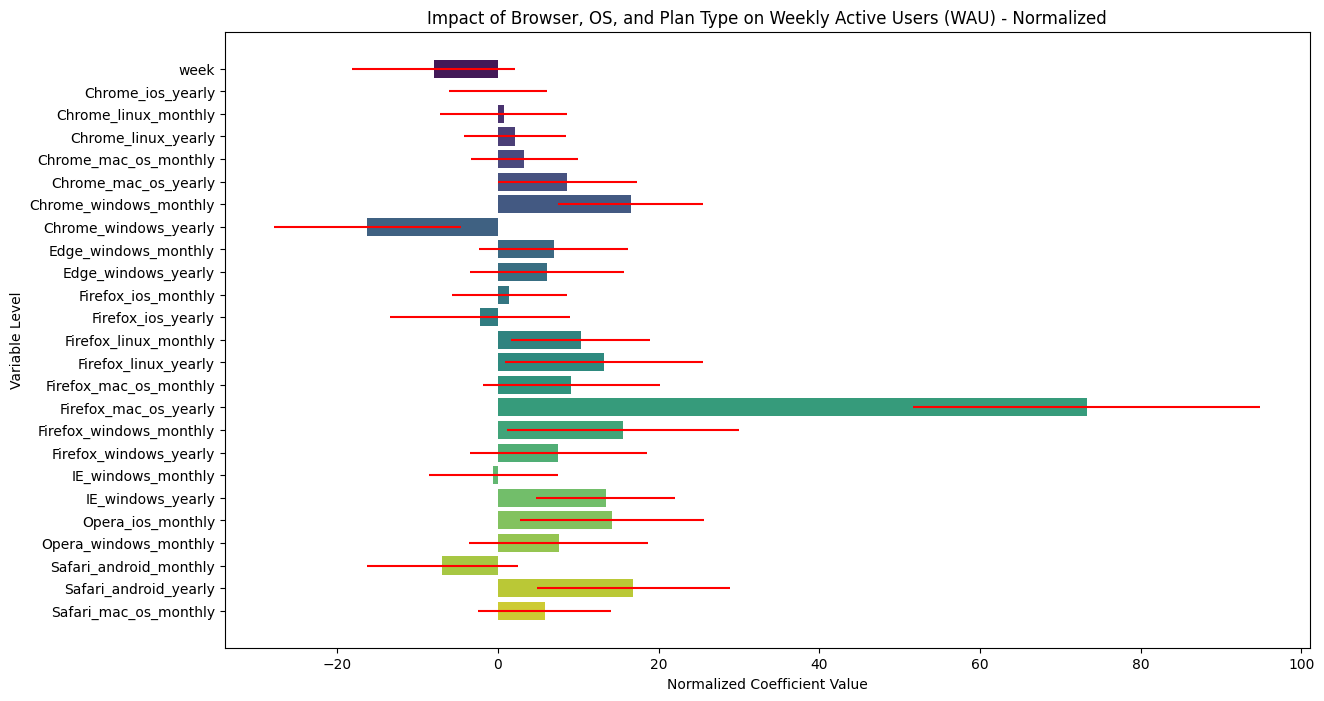

In [97]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the week from the timestamp
df['week'] = df['ts'].dt.to_period('W').astype(str)

# Calculate WAU (Weekly Active Users)
wau = df.groupby('week')['user_id'].nunique().reset_index()
wau.columns = ['week', 'WAU']

# Aggregate data by week, browser, os, and plan
agg_data = df.groupby(['week', 'browser', 'os', 'plan']).size().reset_index(name='task_count')

# Pivot the data to create a matrix
task_matrix = agg_data.pivot_table(index='week', columns=['browser', 'os', 'plan'], values='task_count', fill_value=0)

# Flatten the multi-level columns
task_matrix.columns = ['_'.join(col).strip() for col in task_matrix.columns.values]

# Reset index to prepare for merge
task_matrix.reset_index(inplace=True)

# Merge the task matrix with WAU
task_wau_matrix = pd.merge(task_matrix, wau, on='week')

# Prepare the data for regression
X = task_wau_matrix.drop(columns=['week', 'WAU'])
y = task_wau_matrix['WAU']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add a constant to the model (intercept)
X_scaled = sm.add_constant(X_scaled)

# Perform the regression analysis
model = sm.OLS(y, X_scaled).fit()

# Print the summary of the regression model
print(model.summary())

# Extract coefficients and confidence intervals
coefficients = model.params
conf_int = model.conf_int()
conf_int['coef'] = coefficients

# Filter out the constant term
conf_int = conf_int.loc[conf_int.index != 'const']

# Map x1, x2, ... to the original feature names
feature_names = ['const'] + list(task_matrix.columns)
mapping = {f'x{i}': feature_names[i] for i in range(len(feature_names))}
conf_int.index = conf_int.index.map(mapping)

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x='coef', y=conf_int.index, data=conf_int, palette='viridis', ci=None)
plt.errorbar(x=conf_int['coef'], y=conf_int.index, xerr=(conf_int[1] - conf_int['coef']), fmt='none', c='red')
plt.xlabel('Normalized Coefficient Value')
plt.ylabel('Variable Level')
plt.title('Impact of Browser, OS, and Plan Type on Weekly Active Users (WAU) - Normalized')
plt.show()


                            OLS Regression Results                            
Dep. Variable:                    WAU   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     127.1
Date:                Thu, 25 Jul 2024   Prob (F-statistic):           2.59e-55
Time:                        18:27:36   Log-Likelihood:                -499.07
No. Observations:                 108   AIC:                             1050.
Df Residuals:                      82   BIC:                             1120.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        223.8333      2.715     82.447      0.0

/var/folders/wx/9n292s155d122llxsys0ml2h0000gn/T/ipykernel_25415/3227739288.py:63: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='coef', y=conf_int.index, data=conf_int, palette='viridis', ci=None)
/var/folders/wx/9n292s155d122llxsys0ml2h0000gn/T/ipykernel_25415/3227739288.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coef', y=conf_int.index, data=conf_int, palette='viridis', ci=None)


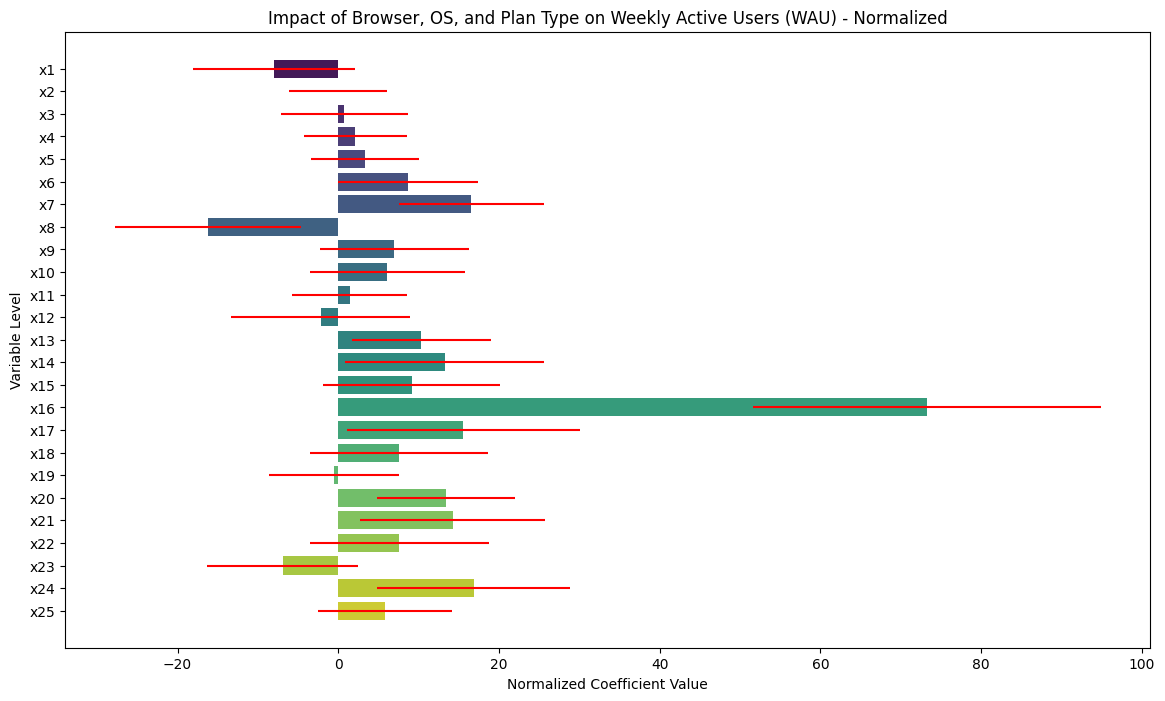

In [72]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the week from the timestamp
df['week'] = df['ts'].dt.to_period('W').astype(str)

# Calculate WAU (Weekly Active Users)
wau = df.groupby('week')['user_id'].nunique().reset_index()
wau.columns = ['week', 'WAU']

# Aggregate data by week, browser, os, and plan
agg_data = df.groupby(['week', 'browser', 'os', 'plan']).size().reset_index(name='task_count')

# Pivot the data to create a matrix
task_matrix = agg_data.pivot_table(index='week', columns=['browser', 'os', 'plan'], values='task_count', fill_value=0)

# Flatten the multi-level columns
task_matrix.columns = ['_'.join(col).strip() for col in task_matrix.columns.values]

# Reset index to prepare for merge
task_matrix.reset_index(inplace=True)

# Merge the task matrix with WAU
task_wau_matrix = pd.merge(task_matrix, wau, on='week')

# Prepare the data for regression
X = task_wau_matrix.drop(columns=['week', 'WAU'])
y = task_wau_matrix['WAU']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add a constant to the model (intercept)
X_scaled = sm.add_constant(X_scaled)

# Perform the regression analysis
model = sm.OLS(y, X_scaled).fit()

# Print the summary of the regression model
print(model.summary())

import matplotlib.pyplot as plt
import seaborn as sns

# Extract coefficients and confidence intervals
coefficients = model.params
conf_int = model.conf_int()
conf_int['coef'] = coefficients

# Filter out the constant term
conf_int = conf_int.loc[conf_int.index != 'const']

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x='coef', y=conf_int.index, data=conf_int, palette='viridis', ci=None)
plt.errorbar(x=conf_int['coef'], y=conf_int.index, xerr=(conf_int[1] - conf_int['coef']), fmt='none', c='red')
plt.xlabel('Normalized Coefficient Value')
plt.ylabel('Variable Level')
plt.title('Impact of Browser, OS, and Plan Type on Weekly Active Users (WAU) - Normalized')
plt.show()



In [73]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the week from the timestamp
df['week'] = df['ts'].dt.to_period('W')

# Calculate WAU (Weekly Active Users)
wau_total = df.groupby('week')['user_id'].nunique().reset_index()
wau_total.columns = ['week', 'total_WAU']

# Calculate WAU for each combination of browser, OS, and plan
wau_combination = df[df['browser'] == 'Opera'][df['os'] == 'ios'][df['plan'] == 'monthly']
wau_combination = wau_combination.groupby('week')['user_id'].nunique().reset_index()
wau_combination.columns = ['week', 'opera_ios_monthly_WAU']

# Merge the total WAU with the combination WAU
wau_combined = pd.merge(wau_total, wau_combination, on='week', how='left').fillna(0)

# Calculate the percentage of WAUs using Opera on iOS with a monthly plan
wau_combined['percentage'] = (wau_combined['opera_ios_monthly_WAU'] / wau_combined['total_WAU']) * 100

# Calculate the average percentage across all weeks
average_percentage = wau_combined['percentage'].mean()

# Display the results
print(wau_combined[['week', 'total_WAU', 'opera_ios_monthly_WAU', 'percentage']])
print(f"Average percentage of WAUs using Opera on iOS with a monthly plan: {average_percentage:.2f}%")


                      week  total_WAU  opera_ios_monthly_WAU  percentage
0    2018-05-21/2018-05-27          1                    0.0         0.0
1    2018-06-04/2018-06-10          1                    0.0         0.0
2    2018-08-20/2018-08-26          1                    0.0         0.0
3    2018-08-27/2018-09-02          2                    0.0         0.0
4    2018-09-03/2018-09-09          1                    0.0         0.0
..                     ...        ...                    ...         ...
103  2021-06-28/2021-07-04        176                    0.0         0.0
104  2021-07-05/2021-07-11        150                    0.0         0.0
105  2021-07-12/2021-07-18        149                    0.0         0.0
106  2021-07-19/2021-07-25        155                    0.0         0.0
107  2021-07-26/2021-08-01         34                    0.0         0.0

[108 rows x 4 columns]
Average percentage of WAUs using Opera on iOS with a monthly plan: 0.01%


/var/folders/wx/9n292s155d122llxsys0ml2h0000gn/T/ipykernel_25415/2498925702.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wau_combination = df[df['browser'] == 'Opera'][df['os'] == 'ios'][df['plan'] == 'monthly']
/var/folders/wx/9n292s155d122llxsys0ml2h0000gn/T/ipykernel_25415/2498925702.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wau_combination = df[df['browser'] == 'Opera'][df['os'] == 'ios'][df['plan'] == 'monthly']


                            OLS Regression Results                            
Dep. Variable:              total_WAU   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.521e+04
Date:                Thu, 25 Jul 2024   Prob (F-statistic):          9.40e-139
Time:                        18:46:14   Log-Likelihood:                -239.26
No. Observations:                 108   AIC:                             532.5
Df Residuals:                      81   BIC:                             604.9
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

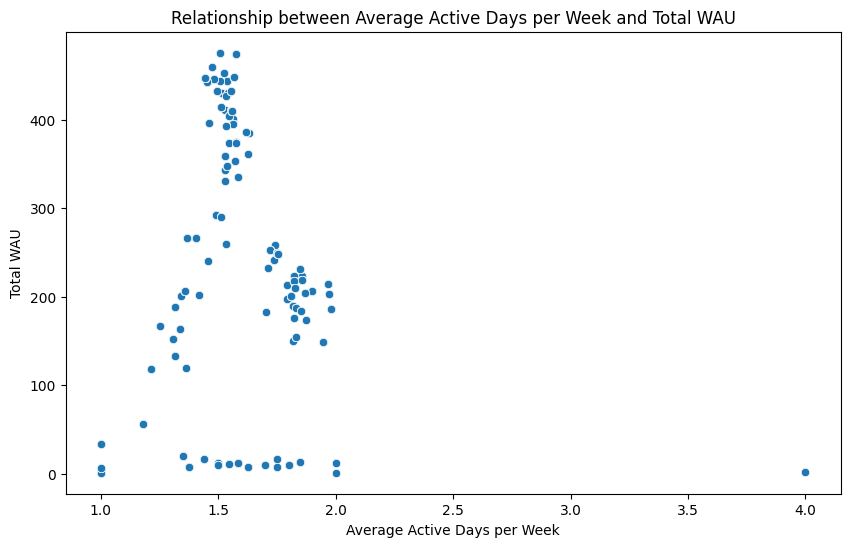

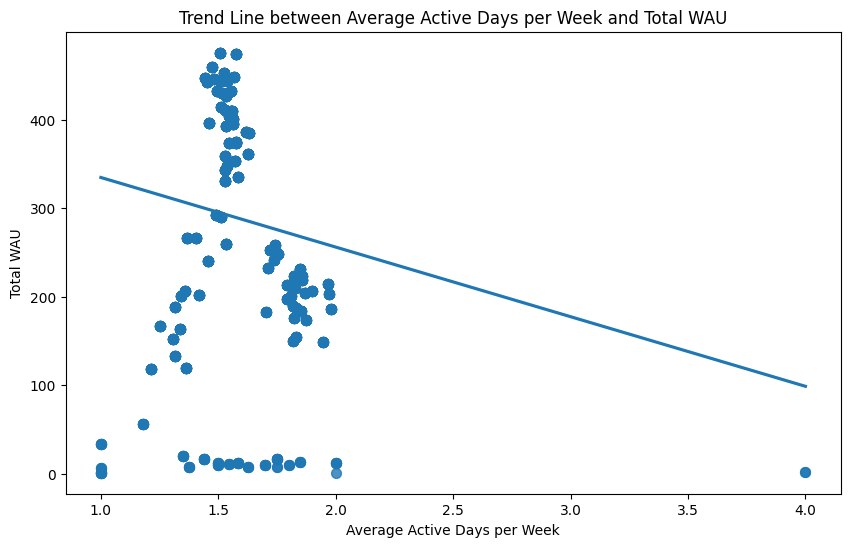

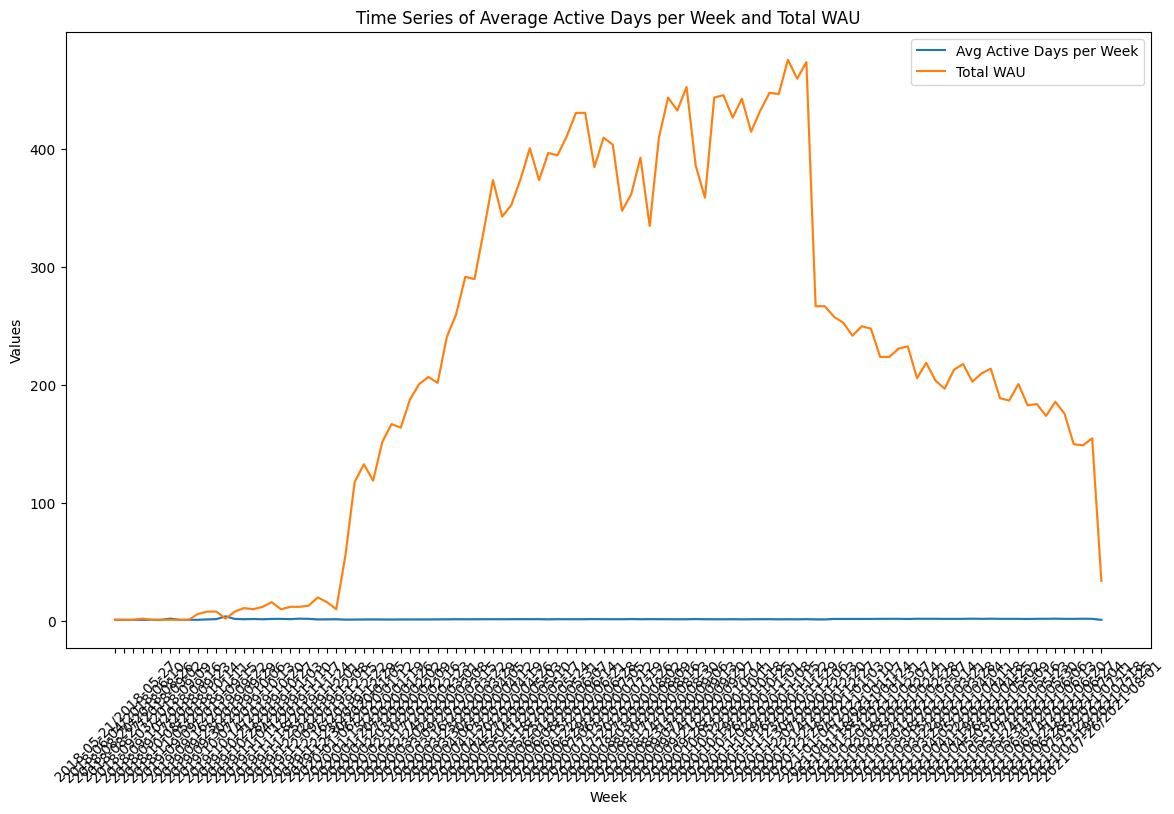

Correlation between Average Active Days per Week and Total WAU:
                          avg_active_days_per_week  total_WAU
avg_active_days_per_week                  1.000000  -0.129237
total_WAU                                -0.129237   1.000000
                            OLS Regression Results                            
Dep. Variable:              total_WAU   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     7.846
Date:                Thu, 25 Jul 2024   Prob (F-statistic):           7.74e-23
Time:                        18:46:16   Log-Likelihood:                -9199.2
No. Observations:                1482   AIC:                         1.844e+04
Df Residuals:                    1460   BIC:                         1.856e+04
Df Model:                          21                                         
Covariance Type:            nonrobust  

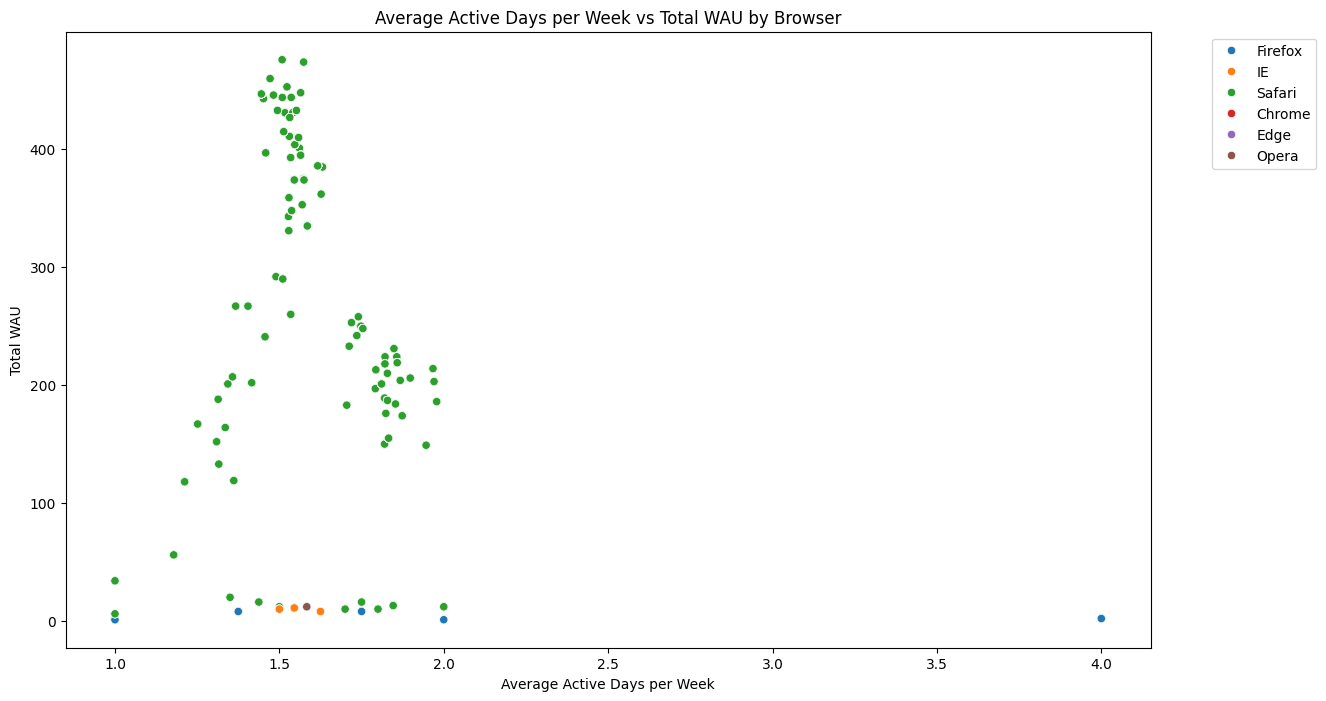

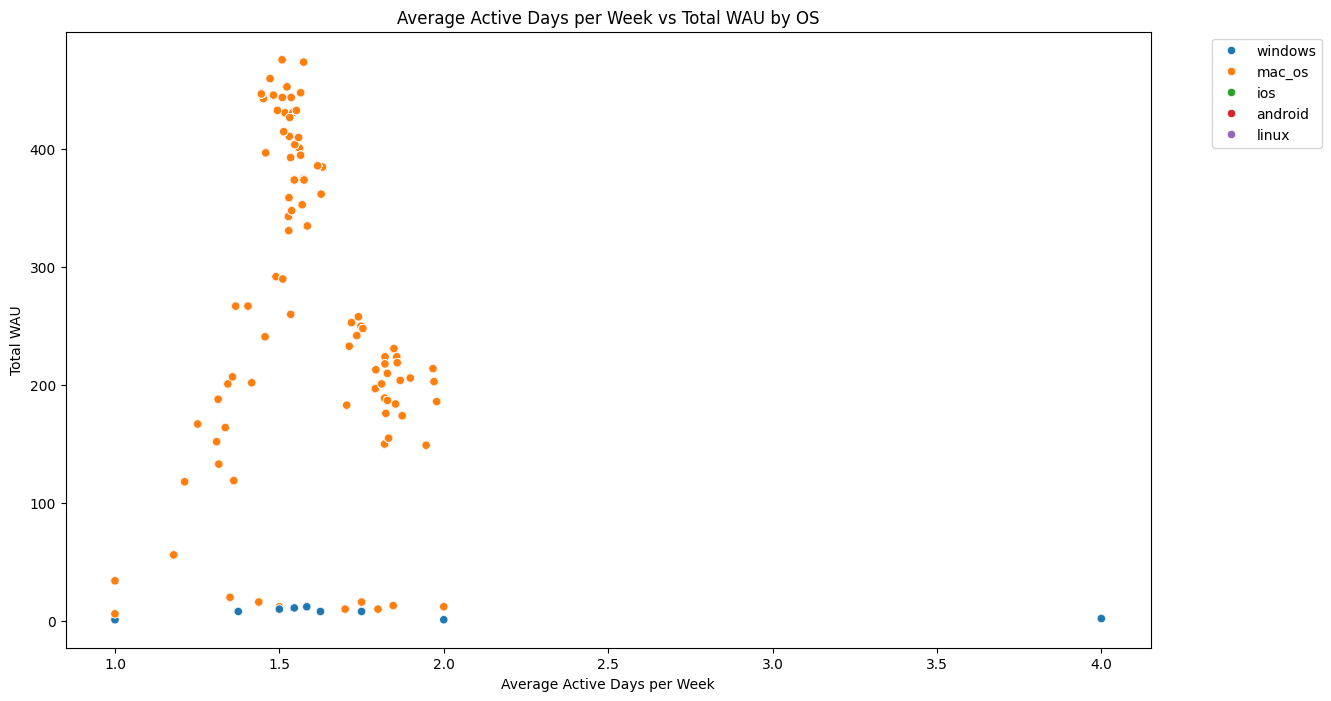

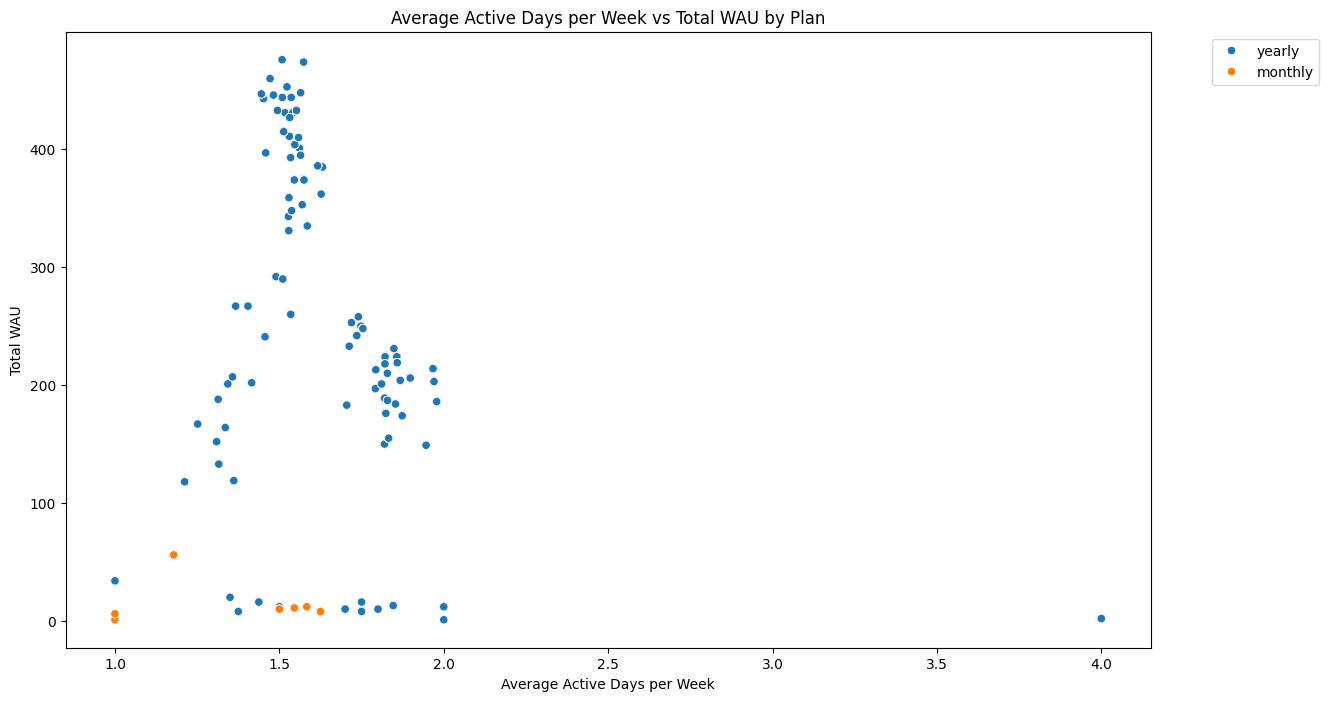

In [78]:
import pandas as pd
import statsmodels.api as sm

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the week from the timestamp
df['week'] = df['ts'].dt.to_period('W').astype(str)

# Calculate WAU (Weekly Active Users)
wau_total = df.groupby('week')['user_id'].nunique().reset_index()
wau_total.columns = ['week', 'total_WAU']

# Calculate active days per week for each user
df['date'] = df['ts'].dt.date
active_days_per_week = df.groupby(['week', 'user_id'])['date'].nunique().reset_index()
active_days_per_week = active_days_per_week.groupby('week')['date'].mean().reset_index()
active_days_per_week.columns = ['week', 'avg_active_days_per_week']

# Aggregate data by week, browser, os, and plan
agg_data = df.groupby(['week', 'browser', 'os', 'plan']).size().reset_index(name='task_count')

# Calculate WAU for each combination of browser, os, and plan
wau_combination = df.groupby(['week', 'browser', 'os', 'plan'])['user_id'].nunique().reset_index()
wau_combination.columns = ['week', 'browser', 'os', 'plan', 'combination_WAU']

# Merge the total WAU with the combination WAU
wau_combined = pd.merge(wau_combination, wau_total, on='week', how='left').fillna(0)

# Merge with active days per week
wau_combined = pd.merge(wau_combined, active_days_per_week, on='week', how='left')

# Calculate the percentage of WAUs for each combination
wau_combined['percentage'] = (wau_combined['combination_WAU'] / wau_combined['total_WAU']) * 100

# Pivot the data to create a matrix for regression analysis
task_matrix = wau_combined.pivot_table(index='week', columns=['browser', 'os', 'plan'], values='combination_WAU', fill_value=0)

# Flatten the multi-level columns
task_matrix.columns = ['_'.join(col).strip() for col in task_matrix.columns.values]

# Reset index to prepare for merge
task_matrix.reset_index(inplace=True)

# Merge the task matrix with total WAU and active days per week
task_wau_matrix = pd.merge(task_matrix, wau_total, on='week')
task_wau_matrix = pd.merge(task_wau_matrix, active_days_per_week, on='week')

# Prepare the data for regression
X = task_wau_matrix.drop(columns=['week', 'total_WAU'])
y = task_wau_matrix['total_WAU']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Perform the regression analysis
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

# Display the WAU percentages for each combination
print(wau_combined[['week', 'browser', 'os', 'plan', 'combination_WAU', 'total_WAU', 'percentage', 'avg_active_days_per_week']])

# Calculate the average percentage for each combination
average_percentage_combination = wau_combined.groupby(['browser', 'os', 'plan'])['percentage'].mean().reset_index()
average_percentage_combination.columns = ['browser', 'os', 'plan', 'average_percentage']

# Display the average WAU percentage for each combination
print(average_percentage_combination)

import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of average active days per week vs total WAU
plt.figure(figsize=(10, 6))
sns.scatterplot(data=wau_combined, x='avg_active_days_per_week', y='total_WAU')
plt.xlabel('Average Active Days per Week')
plt.ylabel('Total WAU')
plt.title('Relationship between Average Active Days per Week and Total WAU')
plt.show()

# Trend line of average active days per week vs total WAU
plt.figure(figsize=(10, 6))
sns.regplot(data=wau_combined, x='avg_active_days_per_week', y='total_WAU', ci=None, scatter_kws={'s': 50})
plt.xlabel('Average Active Days per Week')
plt.ylabel('Total WAU')
plt.title('Trend Line between Average Active Days per Week and Total WAU')
plt.show()




# Time series plot of average active days per week and total WAU
plt.figure(figsize=(14, 8))
sns.lineplot(data=wau_combined, x='week', y='avg_active_days_per_week', label='Avg Active Days per Week')
sns.lineplot(data=wau_combined, x='week', y='total_WAU', label='Total WAU')
plt.xlabel('Week')
plt.ylabel('Values')
plt.title('Time Series of Average Active Days per Week and Total WAU')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Calculate the correlation between average active days per week and total WAU
correlation = wau_combined[['avg_active_days_per_week', 'total_WAU']].corr()
print("Correlation between Average Active Days per Week and Total WAU:")
print(correlation)

import statsmodels.formula.api as smf

# Create a formula to include interaction terms
formula = 'total_WAU ~ avg_active_days_per_week * C(browser) + avg_active_days_per_week * C(os) + avg_active_days_per_week * C(plan)'

# Fit the regression model
interaction_model = smf.ols(formula=formula, data=wau_combined).fit()

# Print the summary of the interaction model
print(interaction_model.summary())
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of average active days per week vs total WAU with hue for browsers
plt.figure(figsize=(14, 8))
sns.scatterplot(data=wau_combined, x='avg_active_days_per_week', y='total_WAU', hue='browser')
plt.xlabel('Average Active Days per Week')
plt.ylabel('Total WAU')
plt.title('Average Active Days per Week vs Total WAU by Browser')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Scatter plot of average active days per week vs total WAU with hue for OS
plt.figure(figsize=(14, 8))
sns.scatterplot(data=wau_combined, x='avg_active_days_per_week', y='total_WAU', hue='os')
plt.xlabel('Average Active Days per Week')
plt.ylabel('Total WAU')
plt.title('Average Active Days per Week vs Total WAU by OS')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Scatter plot of average active days per week vs total WAU with hue for plan
plt.figure(figsize=(14, 8))
sns.scatterplot(data=wau_combined, x='avg_active_days_per_week', y='total_WAU', hue='plan')
plt.xlabel('Average Active Days per Week')
plt.ylabel('Total WAU')
plt.title('Average Active Days per Week vs Total WAU by Plan')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


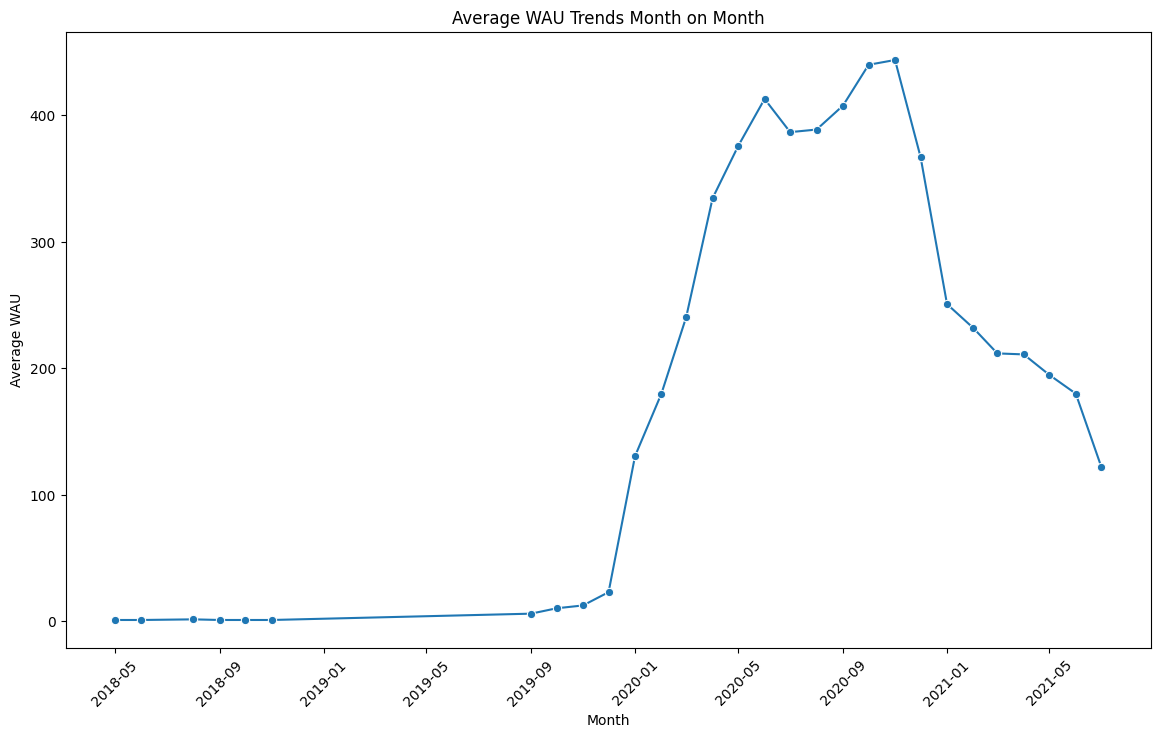

        month  average_WAU
0  2018-05-01         1.00
1  2018-06-01         1.00
2  2018-08-01         1.50
3  2018-09-01         1.00
4  2018-10-01         1.00
5  2018-11-01         1.00
6  2019-09-01         6.00
7  2019-10-01        10.25
8  2019-11-01        12.50
9  2019-12-01        23.00
10 2020-01-01       130.50
11 2020-02-01       180.00
12 2020-03-01       240.40
13 2020-04-01       334.50
14 2020-05-01       375.75
15 2020-06-01       413.00
16 2020-07-01       386.75
17 2020-08-01       388.80
18 2020-09-01       407.75
19 2020-10-01       440.00
20 2020-11-01       443.80
21 2020-12-01       367.00
22 2021-01-01       250.75
23 2021-02-01       231.75
24 2021-03-01       211.80
25 2021-04-01       211.00
26 2021-05-01       194.80
27 2021-06-01       180.00
28 2021-07-01       122.00


In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the week and month from the timestamp
df['week'] = df['ts'].dt.to_period('W').apply(lambda r: r.start_time)
df['month'] = df['ts'].dt.to_period('M').apply(lambda r: r.start_time)

# Calculate WAU (Weekly Active Users)
wau = df.groupby('week')['user_id'].nunique().reset_index()
wau.columns = ['week', 'WAU']

# Extract the month from the week
wau['month'] = wau['week'].dt.to_period('M').apply(lambda r: r.start_time)

# Calculate the average WAU for each month
monthly_wau = wau.groupby('month')['WAU'].mean().reset_index()
monthly_wau.columns = ['month', 'average_WAU']

# Convert 'month' to datetime for plotting
monthly_wau['month'] = pd.to_datetime(monthly_wau['month'])

# Plot the average WAU trends month on month
plt.figure(figsize=(14, 8))
sns.lineplot(data=monthly_wau, x='month', y='average_WAU', marker='o')
plt.xlabel('Month')
plt.ylabel('Average WAU')
plt.title('Average WAU Trends Month on Month')
plt.xticks(rotation=45)
plt.show()

# Display the monthly WAU data
print(monthly_wau)


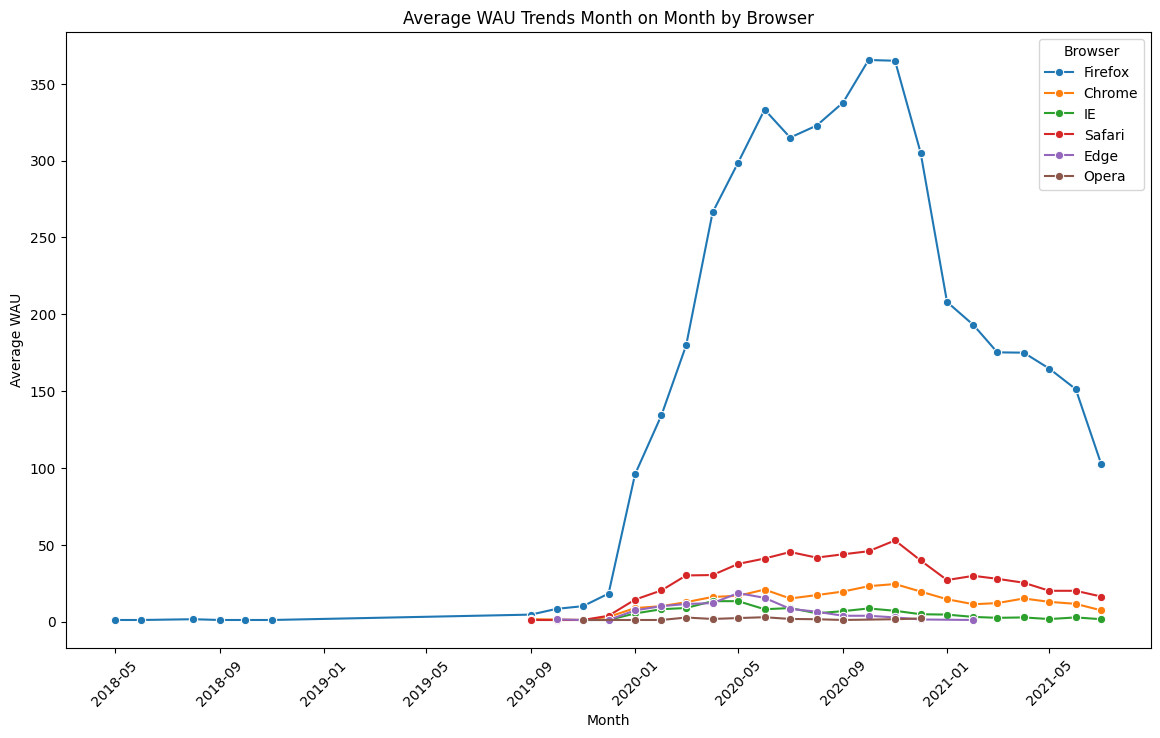

         month  browser     WAU
0   2018-05-01  Firefox    1.00
1   2018-06-01  Firefox    1.00
2   2018-08-01  Firefox    1.50
3   2018-09-01  Firefox    1.00
4   2018-10-01  Firefox    1.00
..         ...      ...     ...
120 2021-06-01   Safari   20.00
121 2021-07-01   Chrome    7.25
122 2021-07-01  Firefox  102.25
123 2021-07-01       IE    1.50
124 2021-07-01   Safari   16.25

[125 rows x 3 columns]


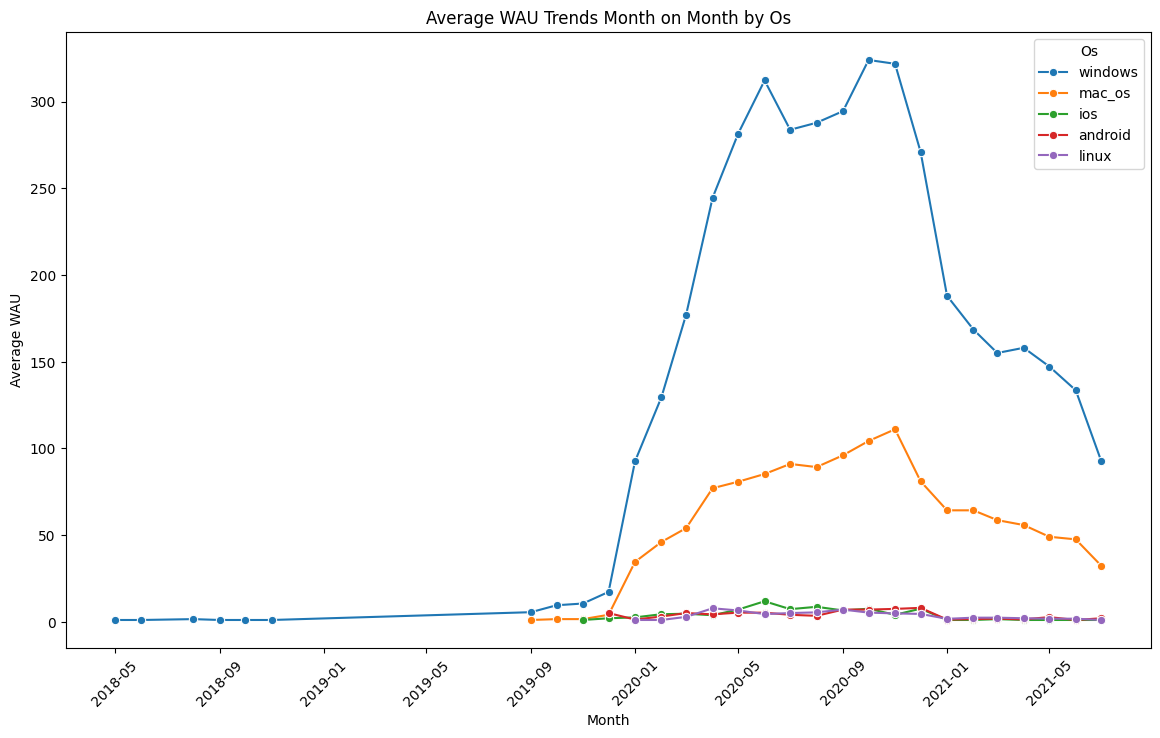

         month       os    WAU
0   2018-05-01  windows   1.00
1   2018-06-01  windows   1.00
2   2018-08-01  windows   1.50
3   2018-09-01  windows   1.00
4   2018-10-01  windows   1.00
..         ...      ...    ...
106 2021-07-01  android   2.00
107 2021-07-01      ios   1.00
108 2021-07-01    linux   1.00
109 2021-07-01   mac_os  32.25
110 2021-07-01  windows  92.50

[111 rows x 3 columns]


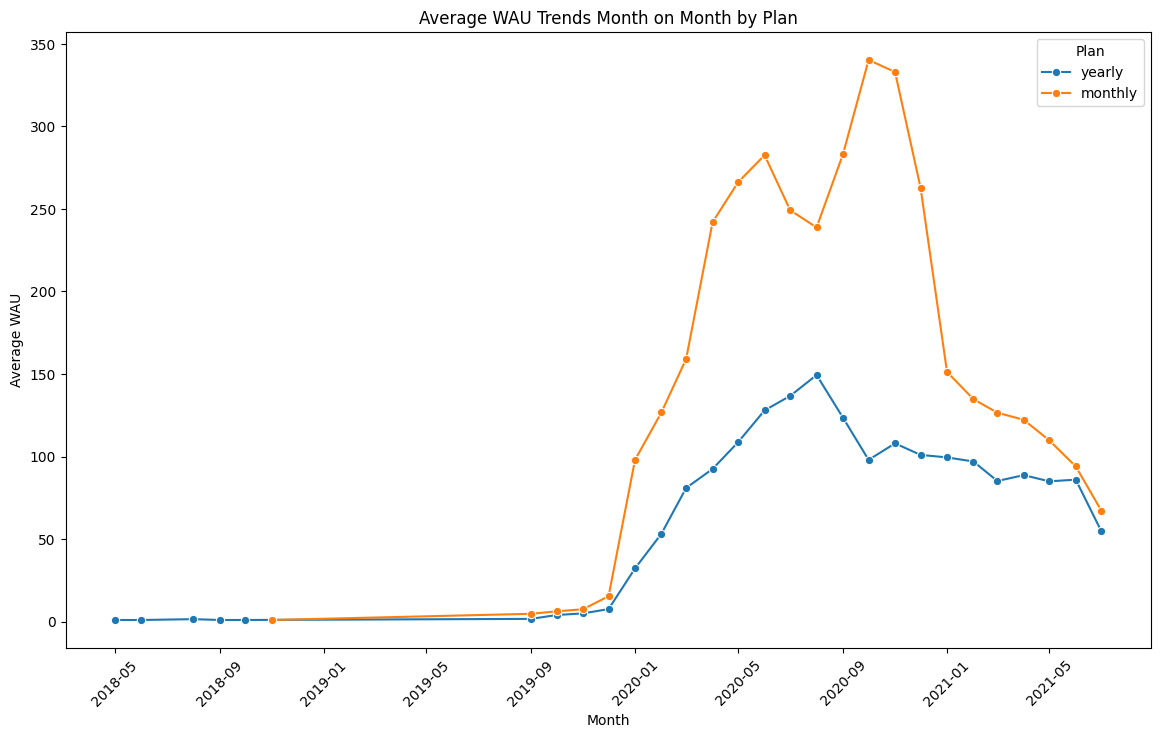

        month     plan         WAU
0  2018-05-01   yearly    1.000000
1  2018-06-01   yearly    1.000000
2  2018-08-01   yearly    1.500000
3  2018-09-01   yearly    1.000000
4  2018-10-01   yearly    1.000000
5  2018-11-01  monthly    1.000000
6  2019-09-01  monthly    4.750000
7  2019-09-01   yearly    1.666667
8  2019-10-01  monthly    6.250000
9  2019-10-01   yearly    4.000000
10 2019-11-01  monthly    7.500000
11 2019-11-01   yearly    5.000000
12 2019-12-01  monthly   15.400000
13 2019-12-01   yearly    7.600000
14 2020-01-01  monthly   98.000000
15 2020-01-01   yearly   32.250000
16 2020-02-01  monthly  126.750000
17 2020-02-01   yearly   53.250000
18 2020-03-01  monthly  159.200000
19 2020-03-01   yearly   81.000000
20 2020-04-01  monthly  242.000000
21 2020-04-01   yearly   92.500000
22 2020-05-01  monthly  266.250000
23 2020-05-01   yearly  108.750000
24 2020-06-01  monthly  282.600000
25 2020-06-01   yearly  128.000000
26 2020-07-01  monthly  249.250000
27 2020-07-01   year

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the week and month from the timestamp
df['week'] = df['ts'].dt.to_period('W').apply(lambda r: r.start_time)
df['month'] = df['ts'].dt.to_period('M').apply(lambda r: r.start_time)

# Calculate WAU (Weekly Active Users)
wau = df.groupby('week')['user_id'].nunique().reset_index()
wau.columns = ['week', 'WAU']

# Extract the month from the week
wau['month'] = wau['week'].dt.to_period('M').apply(lambda r: r.start_time)

# Function to calculate and plot monthly WAU trends for a specific dimension
def plot_monthly_wau_by_dimension(df, dimension):
    # Calculate WAU for each week by dimension
    wau_by_dim = df.groupby(['week', dimension])['user_id'].nunique().reset_index()
    wau_by_dim.columns = ['week', dimension, 'WAU']

    # Extract the month from the week
    wau_by_dim['month'] = wau_by_dim['week'].dt.to_period('M').apply(lambda r: r.start_time)

    # Calculate the average WAU for each month by dimension
    monthly_wau_by_dim = wau_by_dim.groupby(['month', dimension])['WAU'].mean().reset_index()

    # Convert 'month' to datetime for plotting
    monthly_wau_by_dim['month'] = pd.to_datetime(monthly_wau_by_dim['month'])

    # Plot the average WAU trends month on month by dimension
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=monthly_wau_by_dim, x='month', y='WAU', hue=dimension, marker='o')
    plt.xlabel('Month')
    plt.ylabel('Average WAU')
    plt.title(f'Average WAU Trends Month on Month by {dimension.capitalize()}')
    plt.xticks(rotation=45)
    plt.legend(title=dimension.capitalize())
    plt.show()

    # Display the monthly WAU data by dimension
    print(monthly_wau_by_dim)

# Plot monthly WAU trends by browser
plot_monthly_wau_by_dimension(df, 'browser')

# Plot monthly WAU trends by OS
plot_monthly_wau_by_dimension(df, 'os')

# Plot monthly WAU trends by plan type
plot_monthly_wau_by_dimension(df, 'plan')


     month  average_WAU
0  2018-05          1.0
1  2018-06          1.0
2  2018-08          1.5
3  2018-09          1.0
4  2018-10          1.0


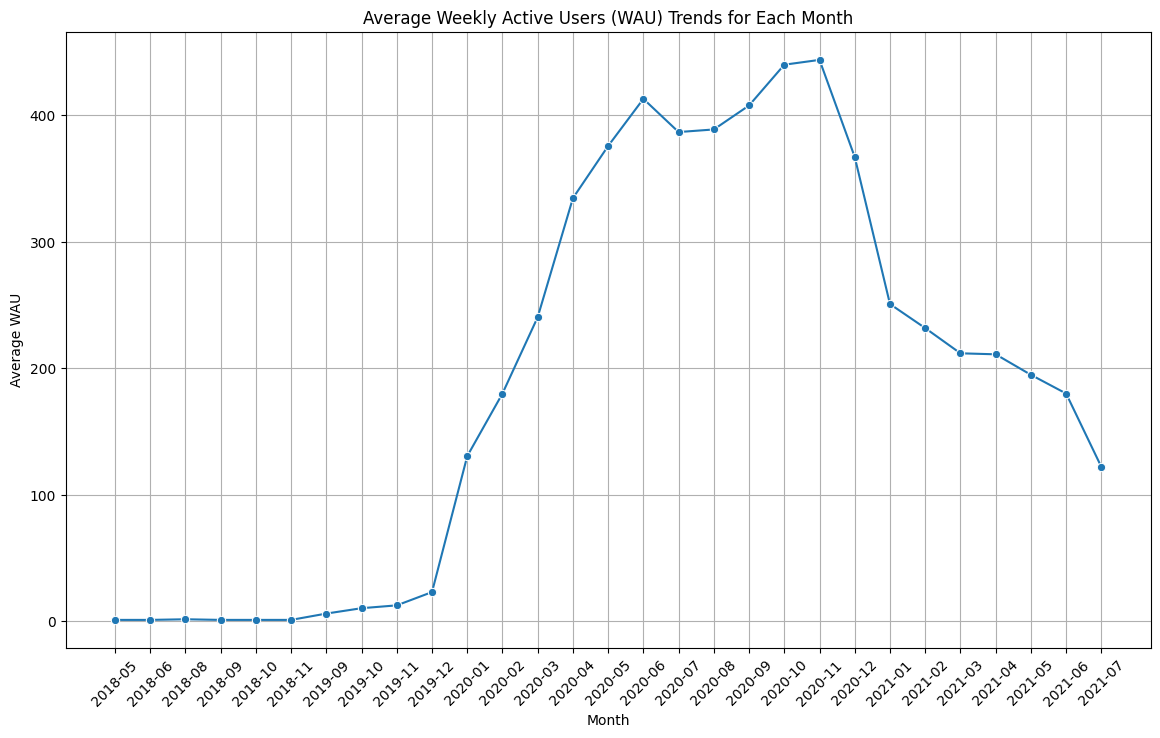

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the week and month from the timestamp
df['week'] = df['ts'].dt.to_period('W')
df['month'] = df['ts'].dt.to_period('M')

# Calculate WAU (Weekly Active Users)
wau = df.groupby('week')['user_id'].nunique().reset_index()
wau.columns = ['week', 'WAU']

# Convert 'week' to the start of the week for consistency
wau['week_start'] = wau['week'].apply(lambda x: x.start_time)

# Extract the month from the week start date
wau['month'] = wau['week_start'].dt.to_period('M')

# Aggregate WAU by month
monthly_wau = wau.groupby('month')['WAU'].mean().reset_index()
monthly_wau.columns = ['month', 'average_WAU']

# Ensure 'month' is of type string for plotting purposes
monthly_wau['month'] = monthly_wau['month'].astype(str)

# Display the first few rows to verify
print(monthly_wau.head())

# Plot average WAU trends for each month
plt.figure(figsize=(14, 8))
sns.lineplot(data=monthly_wau, x='month', y='average_WAU', marker='o')
plt.xlabel('Month')
plt.ylabel('Average WAU')
plt.title('Average Weekly Active Users (WAU) Trends for Each Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [106]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load the dataset
df = pd.read_csv('/Users/kamesh/Downloads/ds-dataset.csv')

# Convert the 'ts' column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract the week from the timestamp
df['week'] = df['ts'].dt.to_period('W')

# Calculate WAU (Weekly Active Users)
wau = df.groupby('week')['user_id'].nunique().reset_index()
wau.columns = ['week', 'WAU']

# Merge WAU back to the main dataframe
df = pd.merge(df, wau, on='week')

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['browser', 'os', 'plan'], drop_first=True)

# Ensure all columns are numeric
df_encoded = df_encoded.apply(pd.to_numeric, errors='coerce')

# Drop any rows with NaN values that may have been introduced by coercion
df_encoded = df_encoded.dropna()

# Prepare the data for regression
X = df_encoded.drop(columns=['ts', 'user_id', 'page', 'week', 'WAU'])
y = df_encoded['WAU']

# Ensure the target variable is numeric
y = pd.to_numeric(y, errors='coerce')

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Build the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).